In [1]:
!git clone https://github.com/ganik/pySSA.git

fatal: destination path 'pySSA' already exists and is not an empty directory.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# SSA

## Price_1

### Price_1 6:3:1

In [3]:
from pySSA.mySSA import mySSA

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# 2. Đọc file dữ liệu chứng khoán AAPL và chia train test validate theo tỉ lệ 7:1:2
df = pd.read_csv('/content/drive/MyDrive/Study/IS403.N22.HTCL/final project/DATASET/Gold_Price_1.csv', parse_dates=True, index_col='Date')
df = df[['Price (VND)']]
df = df.dropna() # Drop missing values
# df = df.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation sets
train_size = int(0.6 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

<ipython-input-4-31896317dca2>:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df = pd.read_csv('/content/drive/MyDrive/Study/IS403.N22.HTCL/final project/DATASET/Gold_Price_1.csv', parse_dates=True, index_col='Date')


In [5]:
test_data = test_data[["Price (VND)"]]
test_data = test_data.reset_index(drop=True)

In [6]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price (VND)'])

ssa = mySSA(train_data)

In [7]:
K = 90
suspected_seasonality = 12

In [8]:
ssa.embed(embedding_dimension=K, suspected_frequency=suspected_seasonality, verbose=True)

----------------------------------------
EMBEDDING SUMMARY:
Embedding dimension	:  84
Trajectory dimensions	: (84, 1525)
Complete dimension	: (84, 1525)
Missing dimension     	: (84, 0)


In [9]:
ssa.decompose(verbose=True)

----------------------------------------
DECOMPOSITION SUMMARY:
Rank of trajectory		: 84
Dimension of projection space	: 5
Characteristic of projection	: 0.9998


/content/pySSA/mySSA.py:153: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])


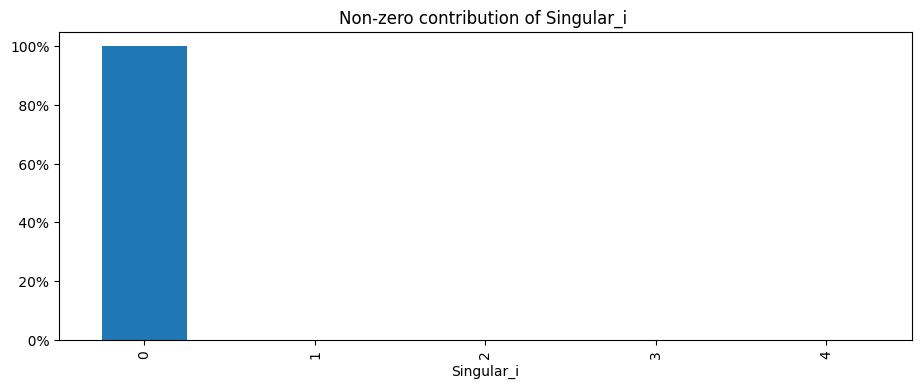

In [10]:
# First enable display of graphs in the notebook
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 11, 4

ssa.view_s_contributions()

/content/pySSA/mySSA.py:153: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])


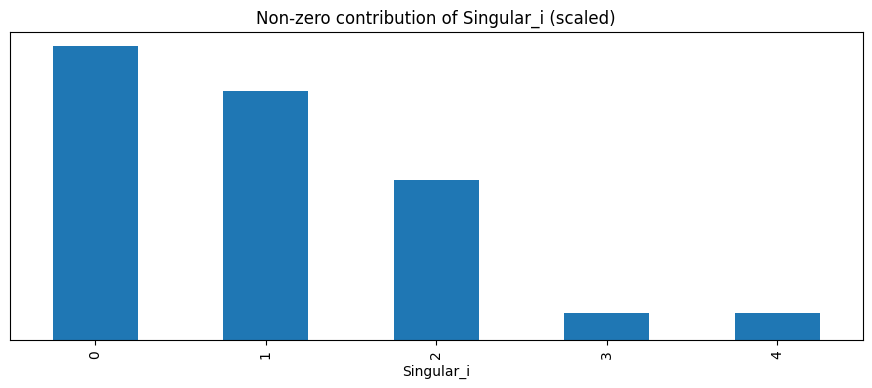

In [11]:
ssa.view_s_contributions(adjust_scale=True)

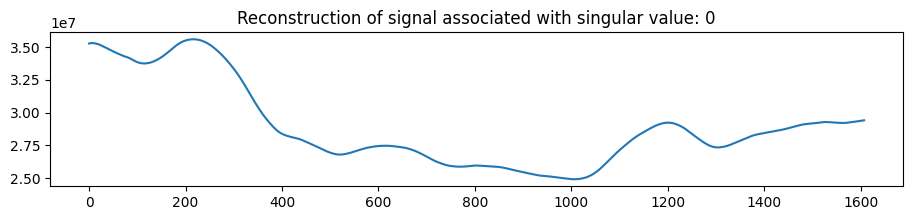

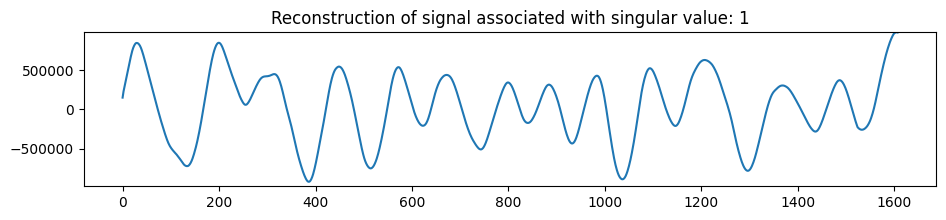

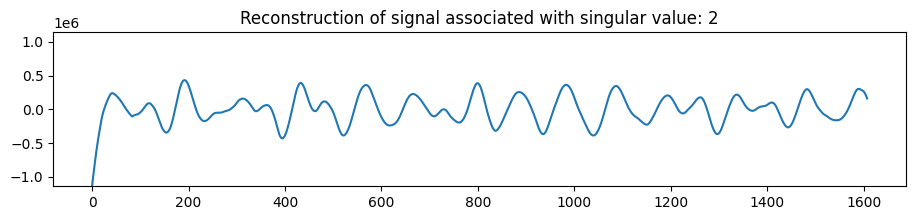

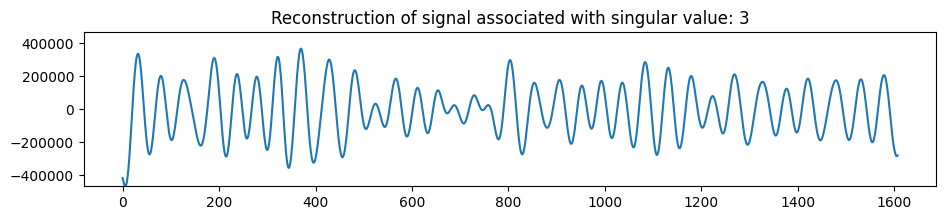

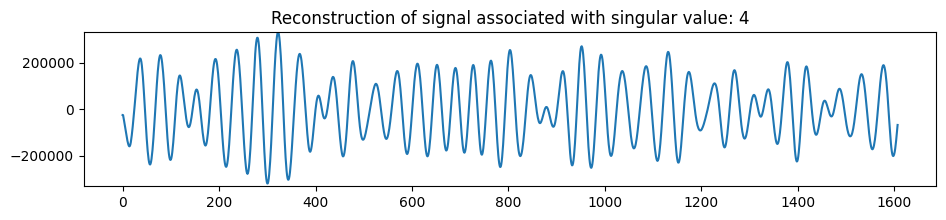

In [12]:
rcParams['figure.figsize'] = 11, 2
for i in range(5):
    ssa.view_reconstruction(ssa.Xs[i], names=i, symmetric_plots=i!=0)
rcParams['figure.figsize'] = 11, 4

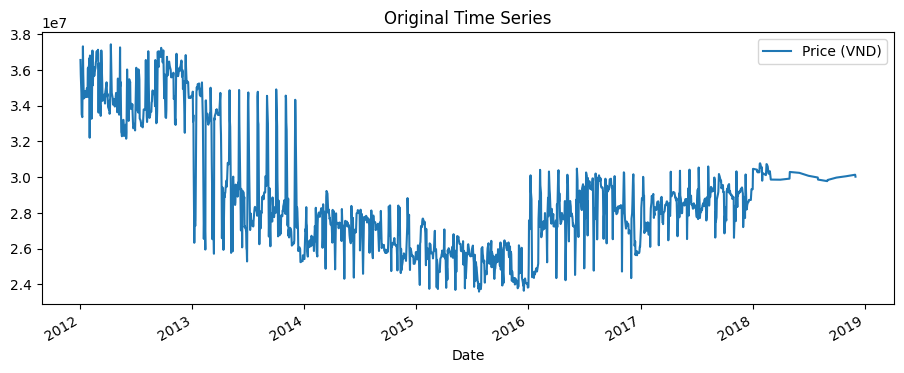

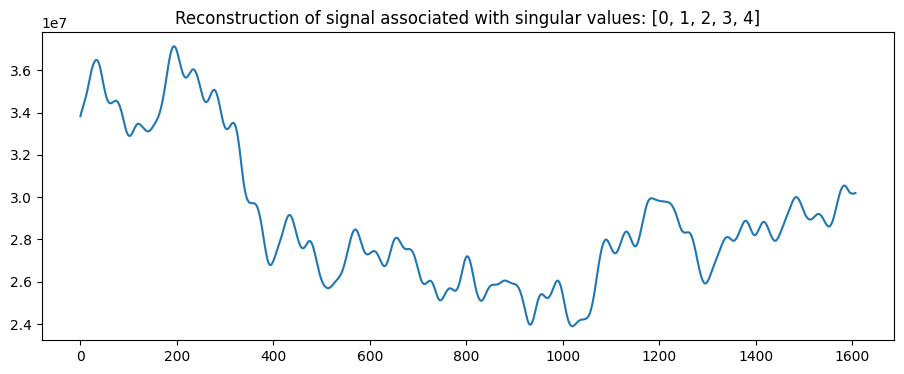

In [13]:
ssa.ts.plot(title='Original Time Series'); # This is the original series for comparison
streams5 = [i for i in range(5)]
reconstructed5 = ssa.view_reconstruction(*[ssa.Xs[i] for i in streams5], names=streams5, return_df=True)

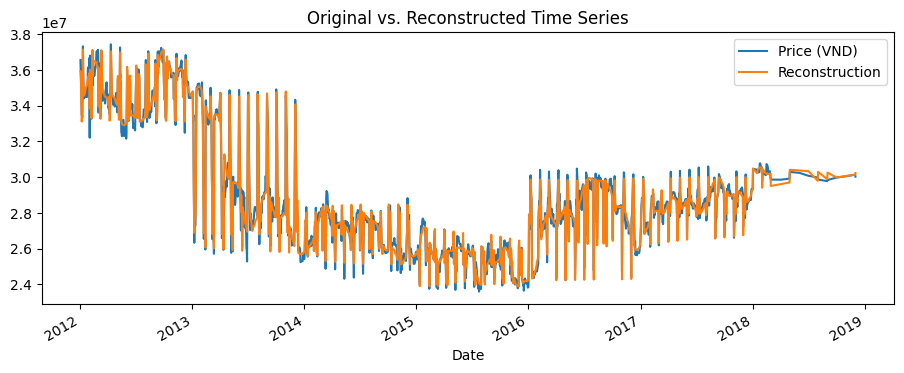

In [14]:
ts_copy5 = ssa.ts.copy()
ts_copy5['Reconstruction'] = reconstructed5.Reconstruction.values
ts_copy5.plot(title='Original vs. Reconstructed Time Series');

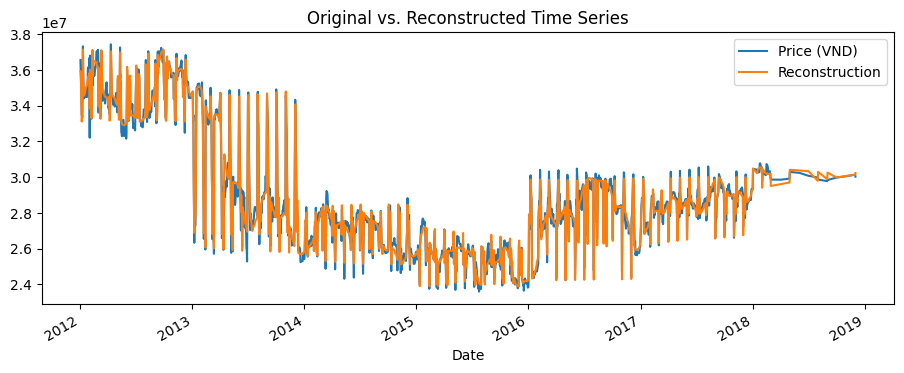

In [15]:
streams10 = [i for i in range(5)]
reconstructed10 = ssa.view_reconstruction(*[ssa.Xs[i] for i in streams10],
                                          names=streams10, return_df=True, plot=False)
ts_copy10 = ssa.ts.copy()
ts_copy10['Reconstruction'] = reconstructed10.Reconstruction.values
ts_copy10.plot(title='Original vs. Reconstructed Time Series');

In [16]:
# 4. Quá trình testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price (VND)'])

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Price (VND)'])

steps_ahead = len(y_test) + len(y_val)
forecast_recurrent_pred = ssa.forecast_recurrent(steps_ahead=steps_ahead, singular_values=streams10, return_df=True)
a = (forecast_recurrent_pred.values[:, 0])[(len(y_train)):]
y_pred = a[:(len(y_test))]
y_pred_val = a[(len(y_test)):]

In [17]:
# 7. Đánh giá độ chính xác validate, test
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE

valid_rmse = np.sqrt(MSE(y_pred_val, y_val))
test_rmse = np.sqrt(MSE(y_test, y_pred))
valid_mape = MAPE(y_pred_val, y_val)*100
test_mape = MAPE(y_test, y_pred)*100
valid_mae = MAE(y_pred_val, y_val)
test_mae = MAE(y_test, y_pred)

print('Validation RMSE:', valid_rmse)
print('Validation MAPE:', valid_mape)
print('Validation MAE:', valid_mae)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Validation RMSE: 14931933.584405001
Validation MAPE: 55.508992421812145
Validation MAE: 14856266.223928338
Testing RMSE: 9129563.573855136
Testing MAPE: 17.23655120755464
Testing MAE: 6809718.212165253


In [18]:
last_index = df.index[-1]
start_index = int(last_index.timestamp())
last_data = pd.RangeIndex(start=start_index, stop=start_index + 30*24*60*60, step=24*60*60)
last_data = pd.Timestamp(last_data[-1], unit='s')

In [19]:
steps_ahead_30 = len(y_test) + len(y_val) + 30
forecast_recurrent_30 = ssa.forecast_recurrent(steps_ahead=steps_ahead_30, singular_values=streams10, return_df=True)
next_30 = (forecast_recurrent_30.values[:, 0])[(len(y_train)):]
y_next_30_days = next_30[(len(y_test)+len(y_val)):]

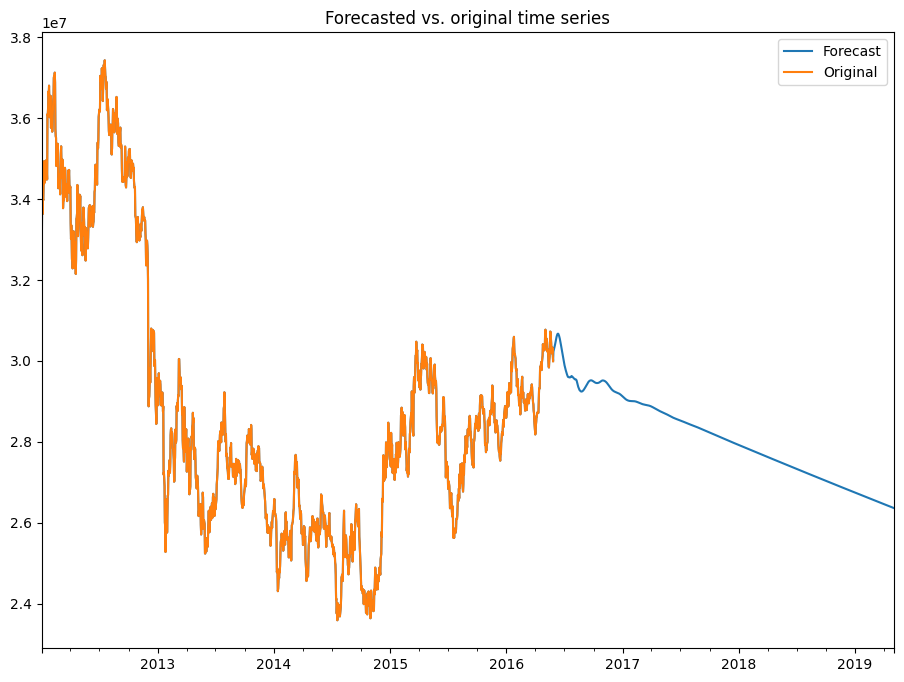

In [20]:
rcParams['figure.figsize'] = 11,8
ssa.forecast_recurrent(steps_ahead=len(y_test) + len(y_val), singular_values=streams10, plot=True)
rcParams['figure.figsize'] = 11, 4

### Price_1 7:2:1

In [1]:
from pySSA.mySSA import mySSA

import pandas as pd
import numpy as np

In [2]:
# 2. Đọc file dữ liệu chứng khoán AAPL và chia train test validate theo tỉ lệ 7:1:2
df = pd.read_csv('/content/drive/MyDrive/Study/IS403.N22.HTCL/final project/DATASET/Gold_Price_1.csv', parse_dates=True, index_col='Date')
df = df[['Price (VND)']]
df = df.dropna() # Drop missing values
# df = df.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

<ipython-input-2-3410fed539a2>:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df = pd.read_csv('/content/drive/MyDrive/Study/IS403.N22.HTCL/final project/DATASET/Gold_Price_1.csv', parse_dates=True, index_col='Date')


In [3]:
test_data = test_data[["Price (VND)"]]
test_data = test_data.reset_index(drop=True)

In [4]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price (VND)'])

ssa = mySSA(train_data)

In [5]:
K = 90
suspected_seasonality = 12

In [6]:
ssa.embed(embedding_dimension=K, suspected_frequency=suspected_seasonality, verbose=True)

----------------------------------------
EMBEDDING SUMMARY:
Embedding dimension	:  84
Trajectory dimensions	: (84, 1792)
Complete dimension	: (84, 1792)
Missing dimension     	: (84, 0)


In [7]:
ssa.decompose(verbose=True)

----------------------------------------
DECOMPOSITION SUMMARY:
Rank of trajectory		: 84
Dimension of projection space	: 5
Characteristic of projection	: 0.9998


/content/pySSA/mySSA.py:153: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])


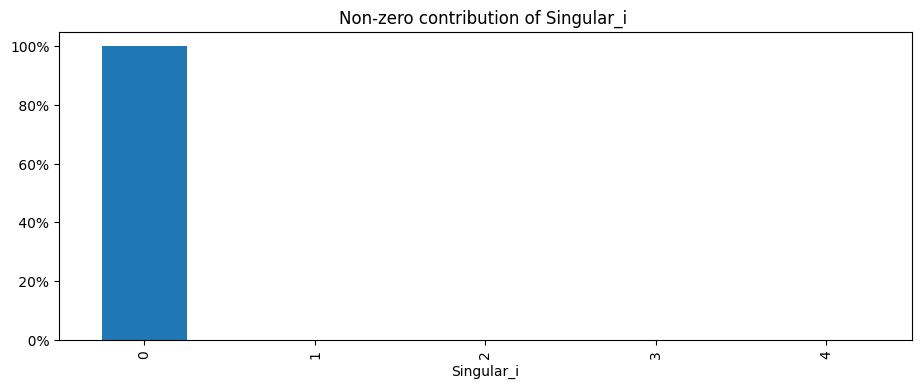

In [8]:
# First enable display of graphs in the notebook
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 11, 4

ssa.view_s_contributions()

/content/pySSA/mySSA.py:153: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])


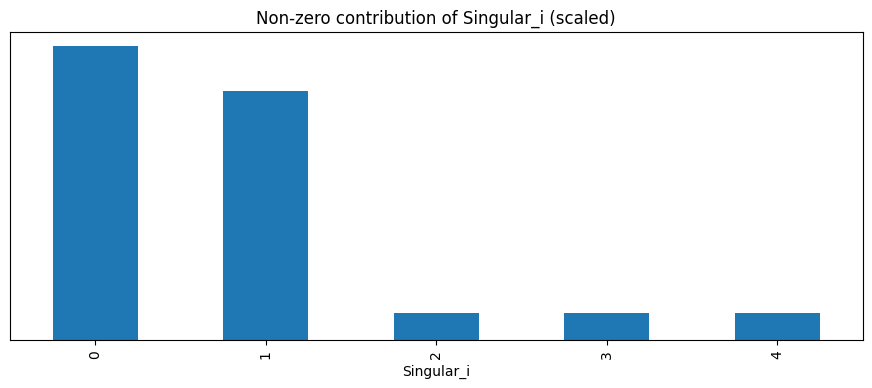

In [9]:
ssa.view_s_contributions(adjust_scale=True)

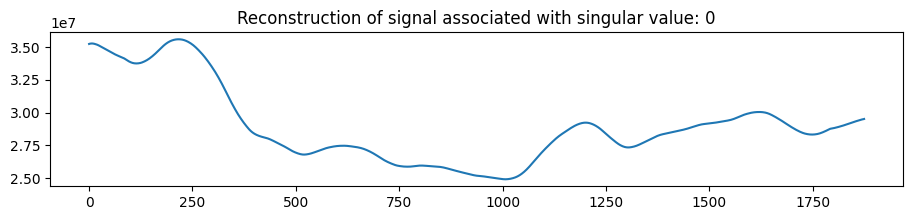

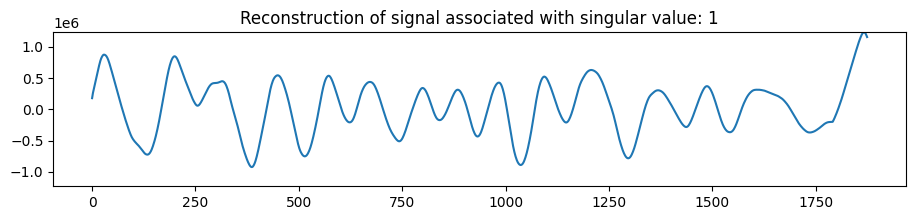

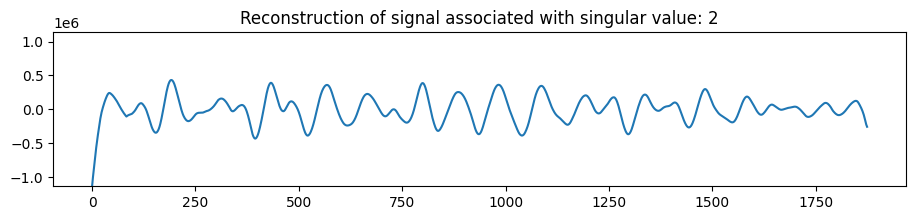

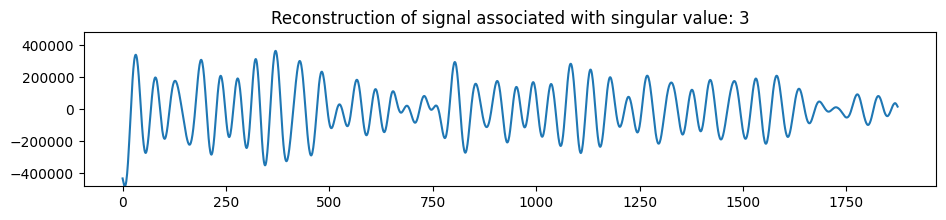

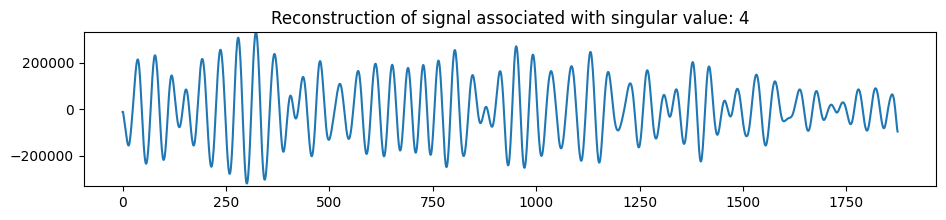

In [10]:
rcParams['figure.figsize'] = 11, 2
for i in range(5):
    ssa.view_reconstruction(ssa.Xs[i], names=i, symmetric_plots=i!=0)
rcParams['figure.figsize'] = 11, 4

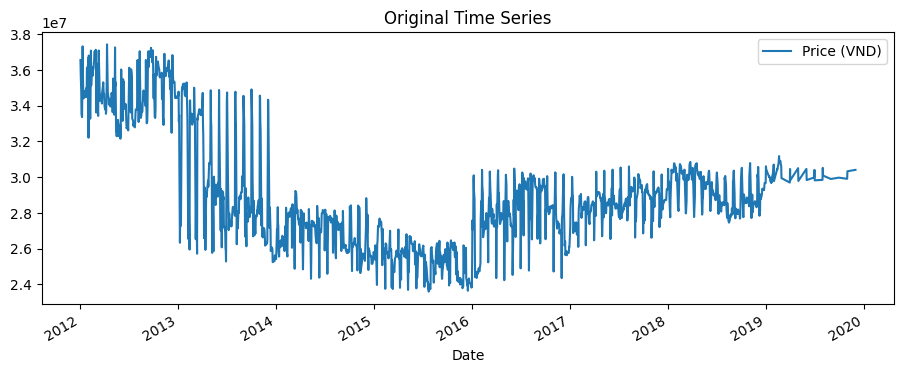

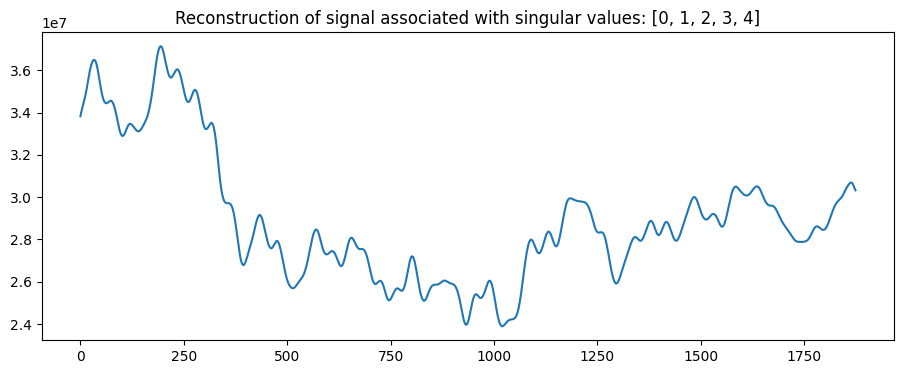

In [11]:
ssa.ts.plot(title='Original Time Series'); # This is the original series for comparison
streams5 = [i for i in range(5)]
reconstructed5 = ssa.view_reconstruction(*[ssa.Xs[i] for i in streams5], names=streams5, return_df=True)

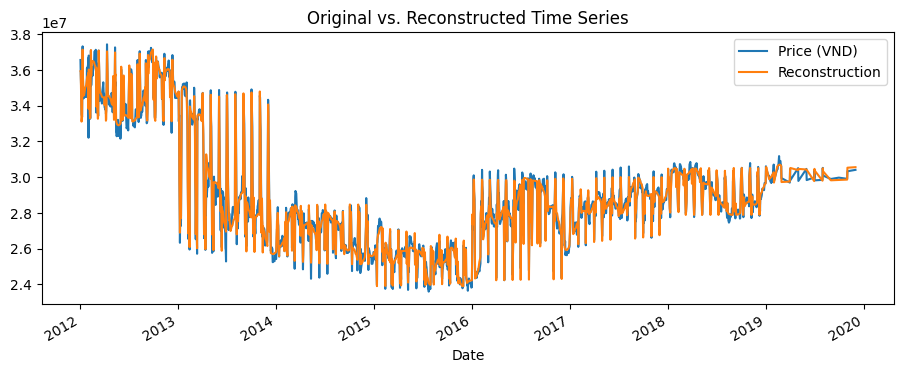

In [12]:
ts_copy5 = ssa.ts.copy()
ts_copy5['Reconstruction'] = reconstructed5.Reconstruction.values
ts_copy5.plot(title='Original vs. Reconstructed Time Series');

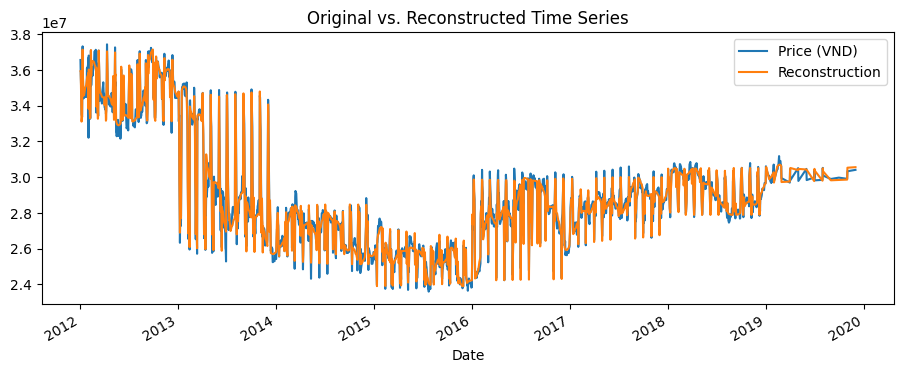

In [13]:
streams10 = [i for i in range(5)]
reconstructed10 = ssa.view_reconstruction(*[ssa.Xs[i] for i in streams10],
                                          names=streams10, return_df=True, plot=False)
ts_copy10 = ssa.ts.copy()
ts_copy10['Reconstruction'] = reconstructed10.Reconstruction.values
ts_copy10.plot(title='Original vs. Reconstructed Time Series');

In [14]:
# 4. Quá trình testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price (VND)'])

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Price (VND)'])

steps_ahead = len(y_test) + len(y_val)
forecast_recurrent_pred = ssa.forecast_recurrent(steps_ahead=steps_ahead, singular_values=streams10, return_df=True)
a = (forecast_recurrent_pred.values[:, 0])[(len(y_train)):]
y_pred = a[:(len(y_test))]
y_pred_val = a[(len(y_test)):]

In [15]:
# 7. Đánh giá độ chính xác validate, test
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE

valid_rmse = np.sqrt(MSE(y_pred_val, y_val))
test_rmse = np.sqrt(MSE(y_test, y_pred))
valid_mape = MAPE(y_pred_val, y_val)*100
test_mape = MAPE(y_test, y_pred)*100
valid_mae = MAE(y_pred_val, y_val)
test_mae = MAE(y_test, y_pred)

print('Validation RMSE:', valid_rmse)
print('Validation MAPE:', valid_mape)
print('Validation MAE:', valid_mae)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Validation RMSE: 14349000.46979472
Validation MAPE: 52.193737096581174
Validation MAE: 14269788.748581951
Testing RMSE: 10688670.428832619
Testing MAPE: 23.072745712094015
Testing MAE: 9286702.743592799


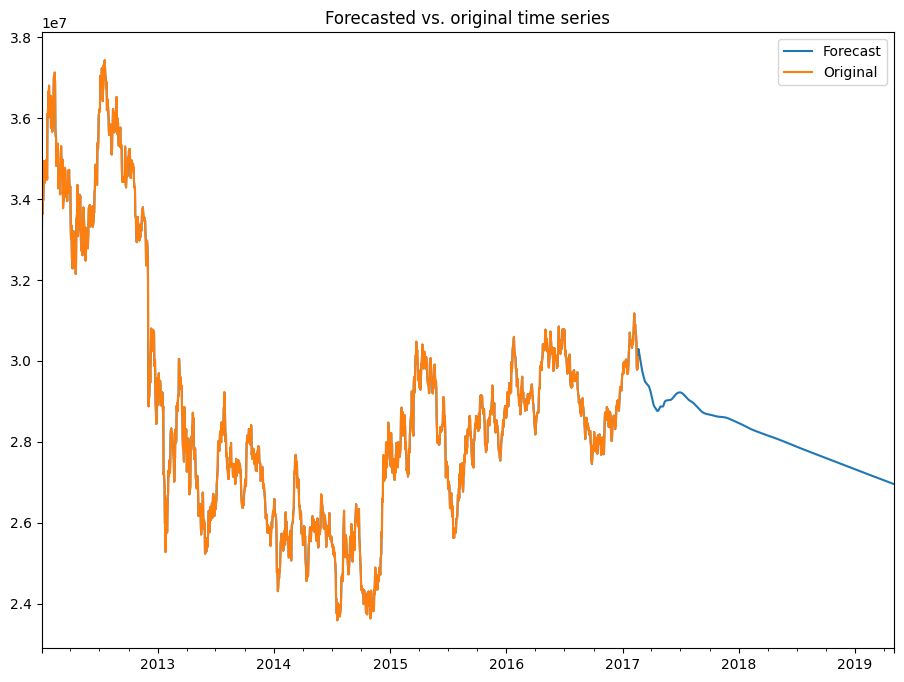

In [16]:
rcParams['figure.figsize'] = 11,8
ssa.forecast_recurrent(steps_ahead=len(y_test) + len(y_val), singular_values=streams10, plot=True)
rcParams['figure.figsize'] = 11, 4

### Price_1 8:1:1

In [1]:
from pySSA.mySSA import mySSA

import pandas as pd
import numpy as np

In [2]:
# 2. Đọc file dữ liệu chứng khoán AAPL và chia train test validate theo tỉ lệ 7:1:2
df = pd.read_csv('/content/drive/MyDrive/Study/IS403.N22.HTCL/final project/DATASET/Gold_Price_1.csv', parse_dates=True, index_col='Date')
df = df[['Price (VND)']]
df = df.dropna() # Drop missing values
# df = df.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation sets
train_size = int(0.8 * len(df))
test_size = int(0.1 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

<ipython-input-2-7ee4c2f9bb58>:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df = pd.read_csv('/content/drive/MyDrive/Study/IS403.N22.HTCL/final project/DATASET/Gold_Price_1.csv', parse_dates=True, index_col='Date')


In [3]:
test_data = test_data[["Price (VND)"]]
test_data = test_data.reset_index(drop=True)

In [4]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price (VND)'])

ssa = mySSA(train_data)

In [5]:
K = 90
suspected_seasonality = 12

In [6]:
ssa.embed(embedding_dimension=K, suspected_frequency=suspected_seasonality, verbose=True)

----------------------------------------
EMBEDDING SUMMARY:
Embedding dimension	:  84
Trajectory dimensions	: (84, 2061)
Complete dimension	: (84, 2061)
Missing dimension     	: (84, 0)


In [7]:
ssa.decompose(verbose=True)

----------------------------------------
DECOMPOSITION SUMMARY:
Rank of trajectory		: 84
Dimension of projection space	: 4
Characteristic of projection	: 0.9998


/content/pySSA/mySSA.py:153: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])


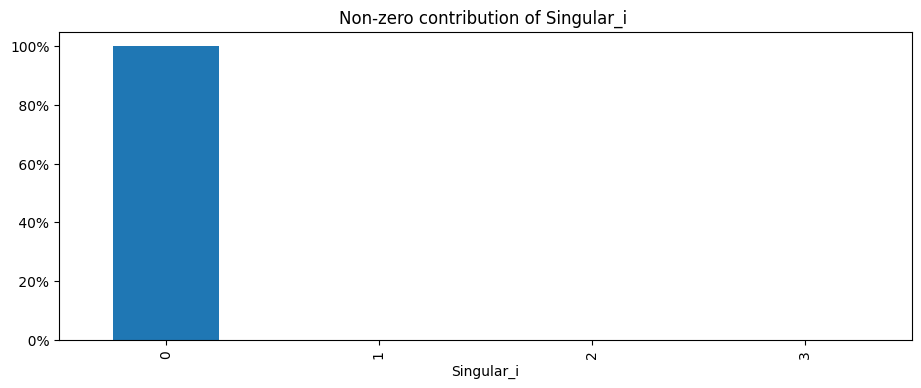

In [8]:
# First enable display of graphs in the notebook
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 11, 4

ssa.view_s_contributions()

/content/pySSA/mySSA.py:153: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])


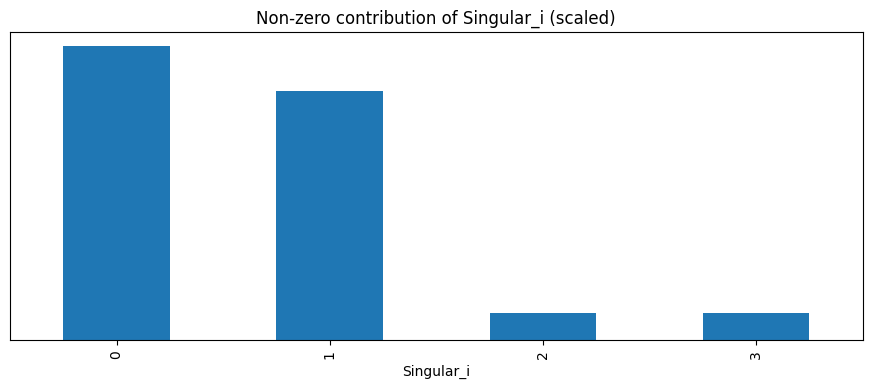

In [9]:
ssa.view_s_contributions(adjust_scale=True)

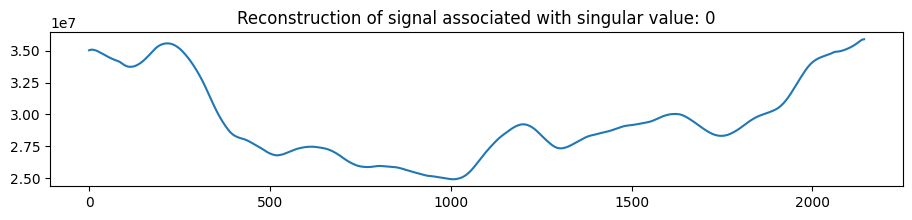

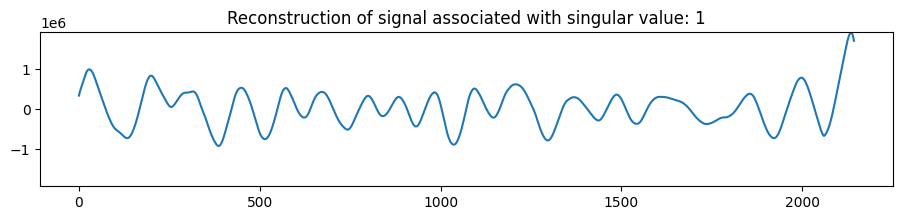

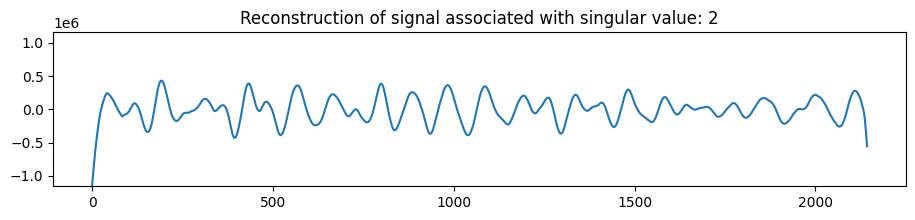

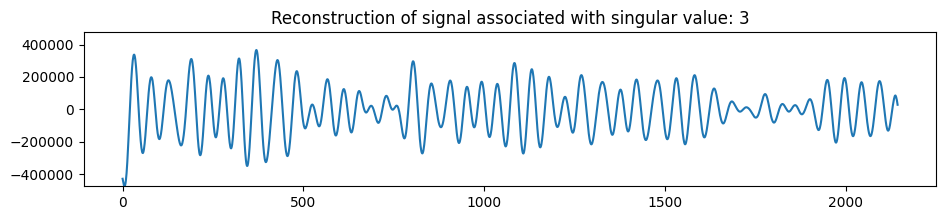

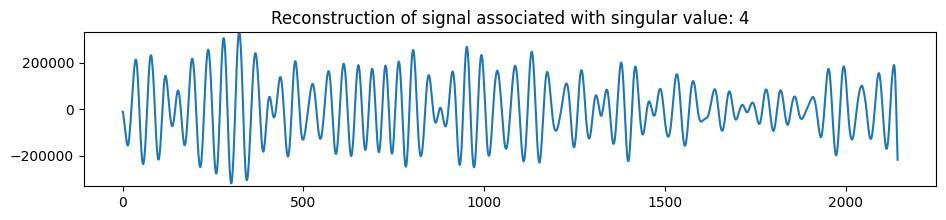

In [10]:
rcParams['figure.figsize'] = 11, 2
for i in range(5):
    ssa.view_reconstruction(ssa.Xs[i], names=i, symmetric_plots=i!=0)
rcParams['figure.figsize'] = 11, 4

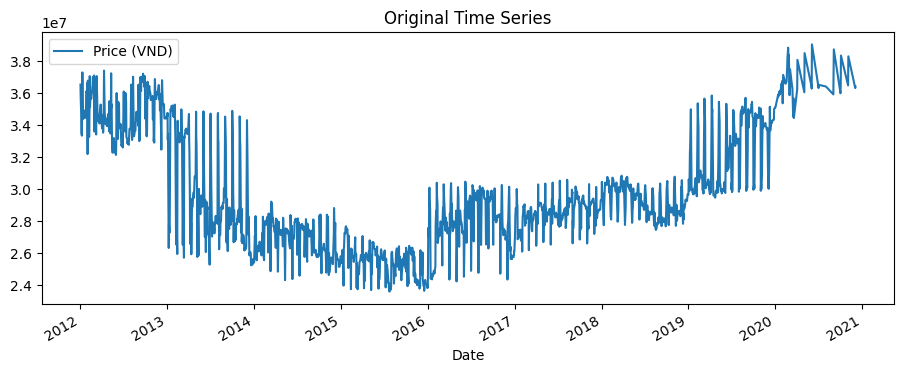

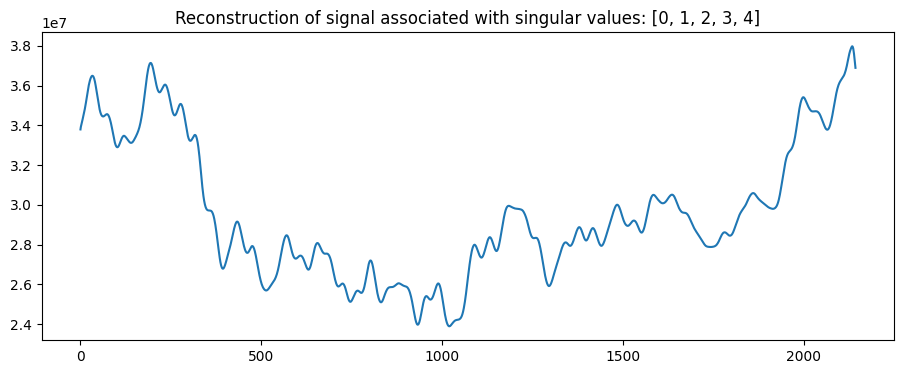

In [11]:
ssa.ts.plot(title='Original Time Series'); # This is the original series for comparison
streams5 = [i for i in range(5)]
reconstructed5 = ssa.view_reconstruction(*[ssa.Xs[i] for i in streams5], names=streams5, return_df=True)

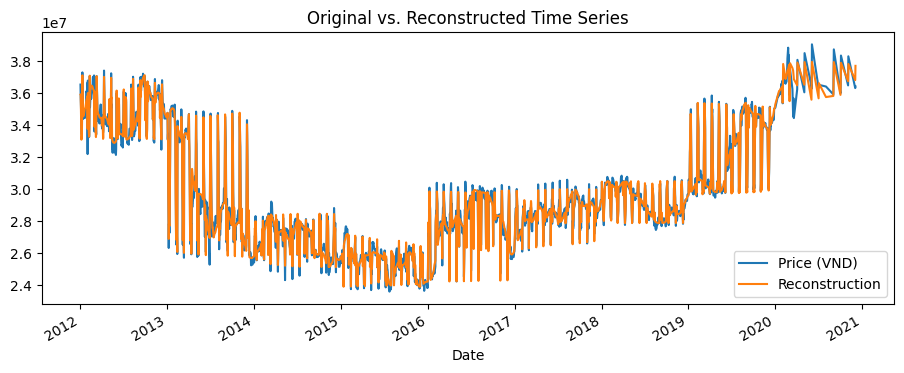

In [12]:
ts_copy5 = ssa.ts.copy()
ts_copy5['Reconstruction'] = reconstructed5.Reconstruction.values
ts_copy5.plot(title='Original vs. Reconstructed Time Series');

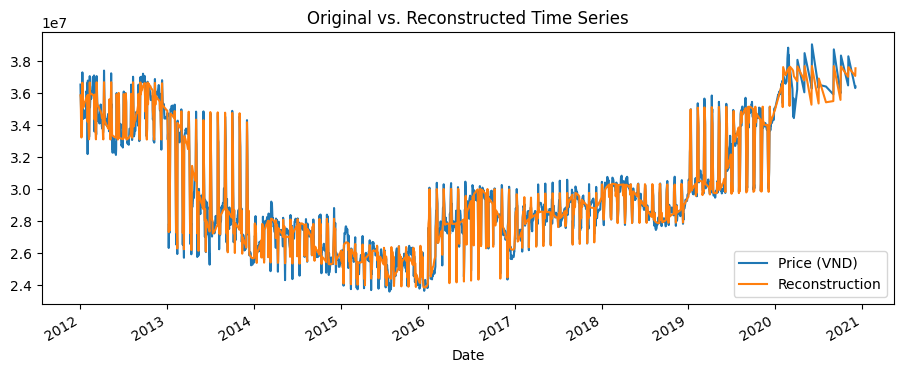

In [13]:
streams10 = [i for i in range(3)]
reconstructed10 = ssa.view_reconstruction(*[ssa.Xs[i] for i in streams10],
                                          names=streams10, return_df=True, plot=False)
ts_copy10 = ssa.ts.copy()
ts_copy10['Reconstruction'] = reconstructed10.Reconstruction.values
ts_copy10.plot(title='Original vs. Reconstructed Time Series');

In [14]:
# 4. Quá trình testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price (VND)'])

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Price (VND)'])

steps_ahead = len(y_test) + len(y_val)
forecast_recurrent_pred = ssa.forecast_recurrent(steps_ahead=steps_ahead, singular_values=streams10, return_df=True)
a = (forecast_recurrent_pred.values[:, 0])[(len(y_train)):]
y_pred = a[:(len(y_test))]
y_pred_val = a[(len(y_test)):]

In [15]:
# 7. Đánh giá độ chính xác validate, test
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE

valid_rmse = np.sqrt(MSE(y_pred_val, y_val))
test_rmse = np.sqrt(MSE(y_test, y_pred))
valid_mape = MAPE(y_pred_val, y_val)*100
test_mape = MAPE(y_test, y_pred)*100
valid_mae = MAE(y_pred_val, y_val)
test_mae = MAE(y_test, y_pred)

print('Validation RMSE:', valid_rmse)
print('Validation MAPE:', valid_mape)
print('Validation MAE:', valid_mae)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Validation RMSE: 6095238.919709194
Validation MAPE: 16.628003729479328
Validation MAE: 5936454.692070304
Testing RMSE: 6956563.114331602
Testing MAPE: 15.376563136399662
Testing MAE: 6579274.989997476


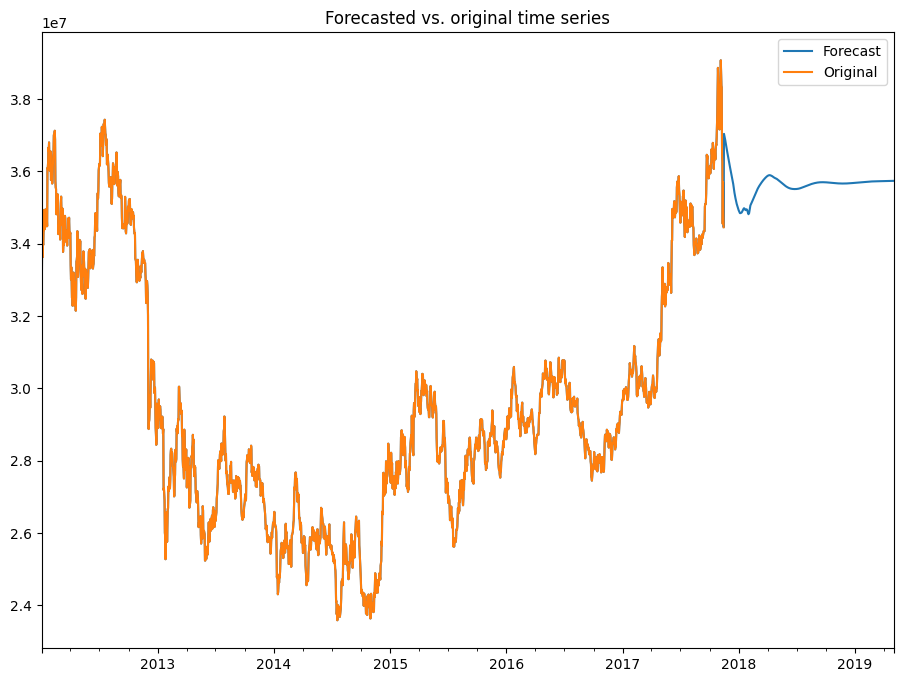

In [16]:
rcParams['figure.figsize'] = 11,8
ssa.forecast_recurrent(steps_ahead=len(y_test) + len(y_val), singular_values=streams10, plot=True)
rcParams['figure.figsize'] = 11, 4

## Price_2

### Price_2 6:3:1

In [1]:
from pySSA.mySSA import mySSA

import pandas as pd
import numpy as np

In [2]:
# 2. Đọc file dữ liệu chứng khoán AAPL và chia train test validate theo tỉ lệ 7:1:2
df = pd.read_csv('/content/drive/MyDrive/Study/IS403.N22.HTCL/final project/DATASET/Gold_Price_2.csv', parse_dates=True, index_col='Date')
df = df[['GLD']]
df = df.dropna() # Drop missing values
# df = df.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation sets
train_size = int(0.6 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [3]:
test_data = test_data[["GLD"]]
test_data = test_data.reset_index(drop=True)

In [4]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['GLD'])

ssa = mySSA(train_data)

In [5]:
K = 90
suspected_seasonality = 12

In [6]:
ssa.embed(embedding_dimension=K, suspected_frequency=suspected_seasonality, verbose=True)

----------------------------------------
EMBEDDING SUMMARY:
Embedding dimension	:  84
Trajectory dimensions	: (84, 1291)
Complete dimension	: (84, 1291)
Missing dimension     	: (84, 0)


In [7]:
ssa.decompose(verbose=True)

----------------------------------------
DECOMPOSITION SUMMARY:
Rank of trajectory		: 84
Dimension of projection space	: 6
Characteristic of projection	: 0.9997


/content/pySSA/mySSA.py:153: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])


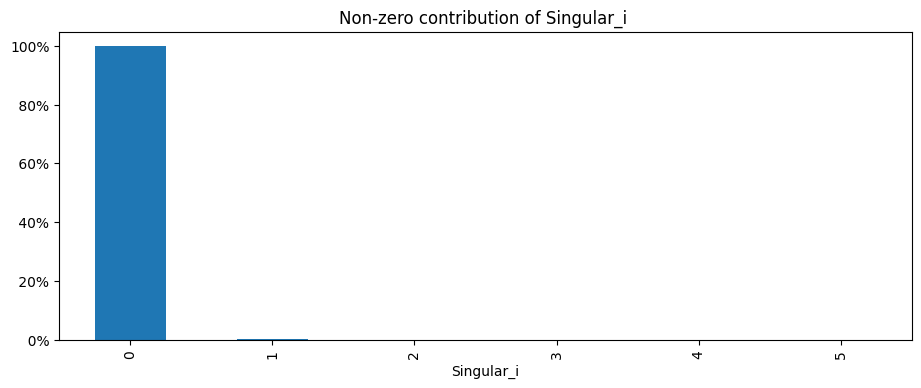

In [8]:
# First enable display of graphs in the notebook
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 11, 4

ssa.view_s_contributions()

/content/pySSA/mySSA.py:153: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])


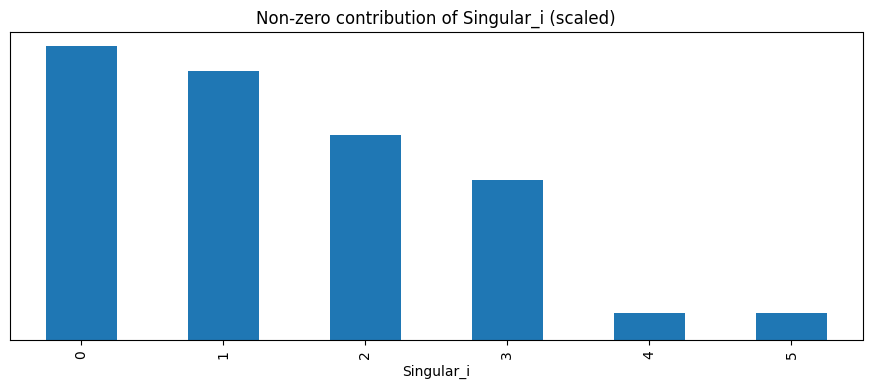

In [9]:
ssa.view_s_contributions(adjust_scale=True)

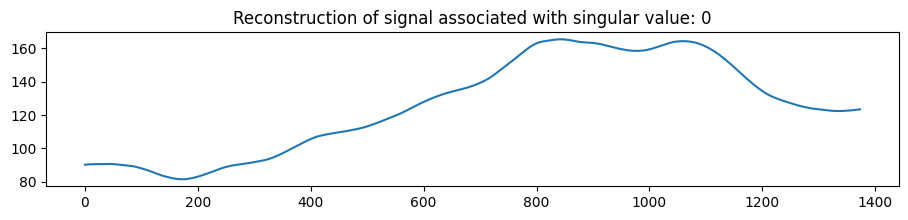

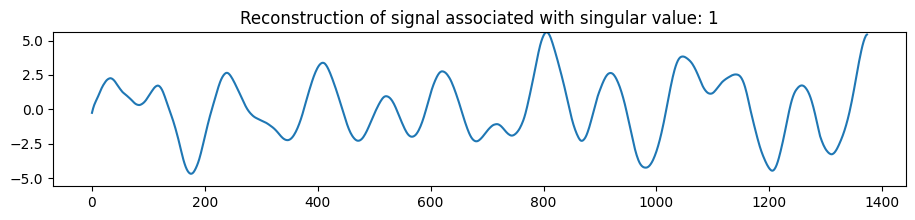

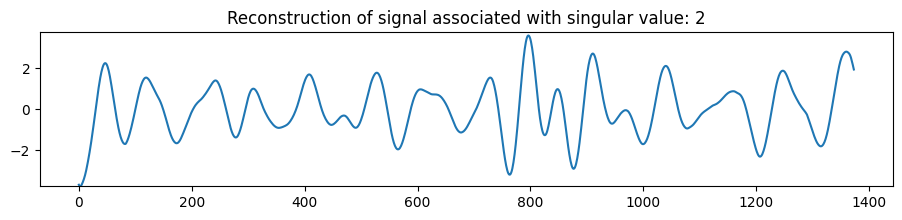

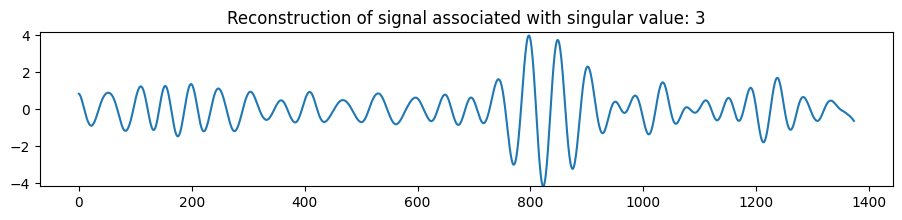

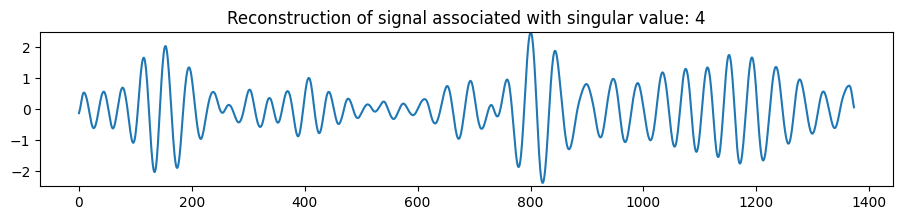

In [10]:
rcParams['figure.figsize'] = 11, 2
for i in range(5):
    ssa.view_reconstruction(ssa.Xs[i], names=i, symmetric_plots=i!=0)
rcParams['figure.figsize'] = 11, 4

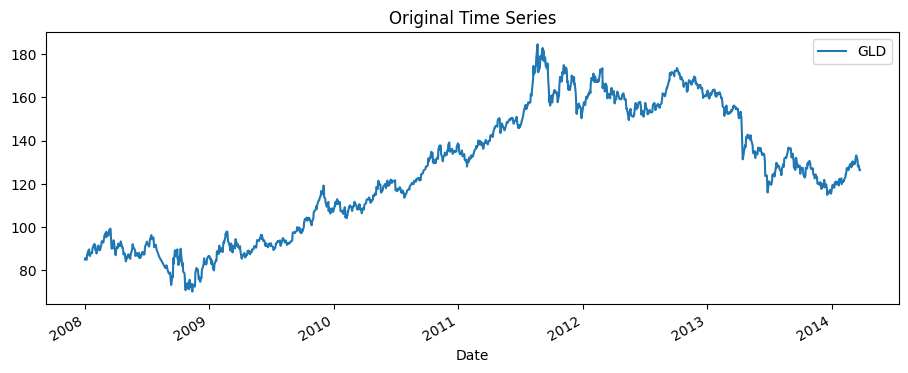

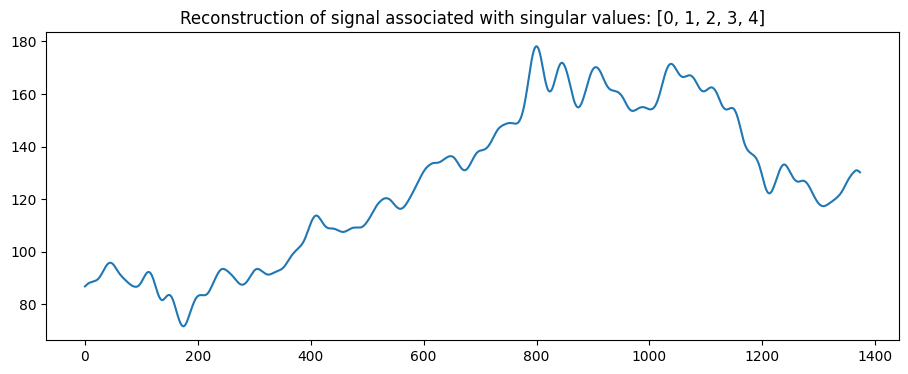

In [11]:
ssa.ts.plot(title='Original Time Series'); # This is the original series for comparison
streams5 = [i for i in range(5)]
reconstructed5 = ssa.view_reconstruction(*[ssa.Xs[i] for i in streams5], names=streams5, return_df=True)

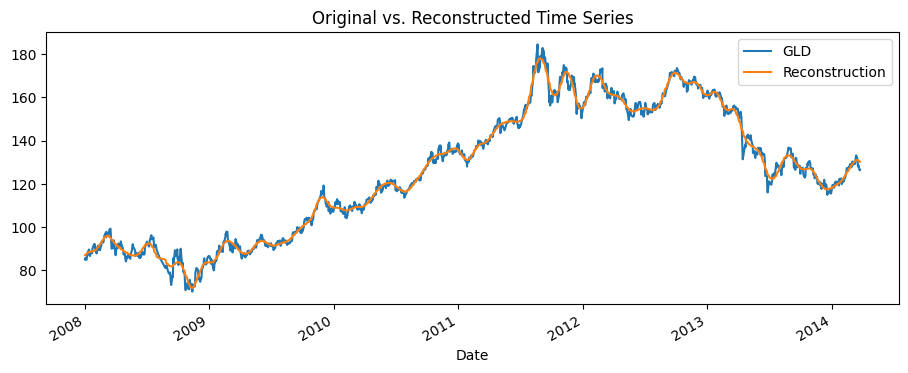

In [12]:
ts_copy5 = ssa.ts.copy()
ts_copy5['Reconstruction'] = reconstructed5.Reconstruction.values
ts_copy5.plot(title='Original vs. Reconstructed Time Series');

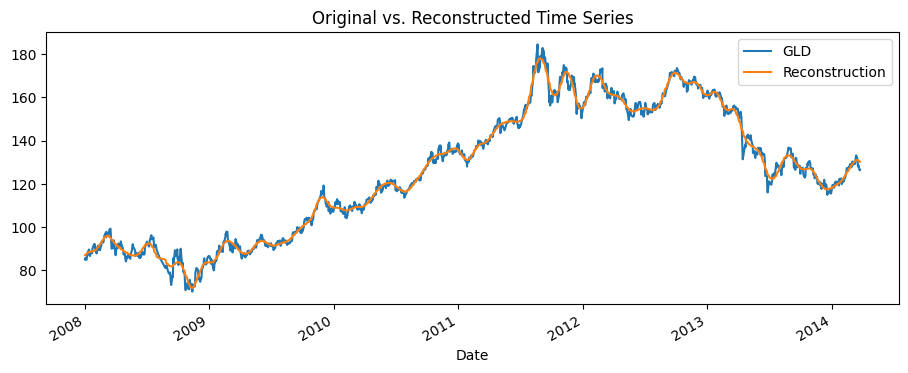

In [13]:
streams10 = [i for i in range(5)]
reconstructed10 = ssa.view_reconstruction(*[ssa.Xs[i] for i in streams10],
                                          names=streams10, return_df=True, plot=False)
ts_copy10 = ssa.ts.copy()
ts_copy10['Reconstruction'] = reconstructed10.Reconstruction.values
ts_copy10.plot(title='Original vs. Reconstructed Time Series');

In [14]:
# 4. Quá trình testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['GLD'])

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['GLD'])

steps_ahead = len(y_test) + len(y_val)
forecast_recurrent_pred = ssa.forecast_recurrent(steps_ahead=steps_ahead, singular_values=streams10, return_df=True)
a = (forecast_recurrent_pred.values[:, 0])[(len(y_train)):]
y_pred = a[:(len(y_test))]
y_pred_val = a[(len(y_test)):]

In [15]:
# 7. Đánh giá độ chính xác validate, test
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE

valid_rmse = np.sqrt(MSE(y_pred_val, y_val))
test_rmse = np.sqrt(MSE(y_test, y_pred))
valid_mape = MAPE(y_pred_val, y_val)*100
test_mape = MAPE(y_test, y_pred)*100
valid_mae = MAE(y_pred_val, y_val)
test_mae = MAE(y_test, y_pred)

print('Validation RMSE:', valid_rmse)
print('Validation MAPE:', valid_mape)
print('Validation MAE:', valid_mae)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Validation RMSE: 21.424422590231885
Validation MAPE: 14.783165160135859
Validation MAE: 21.289093176980575
Testing RMSE: 19.622709249228016
Testing MAPE: 15.714637677863502
Testing MAE: 17.81674316451686


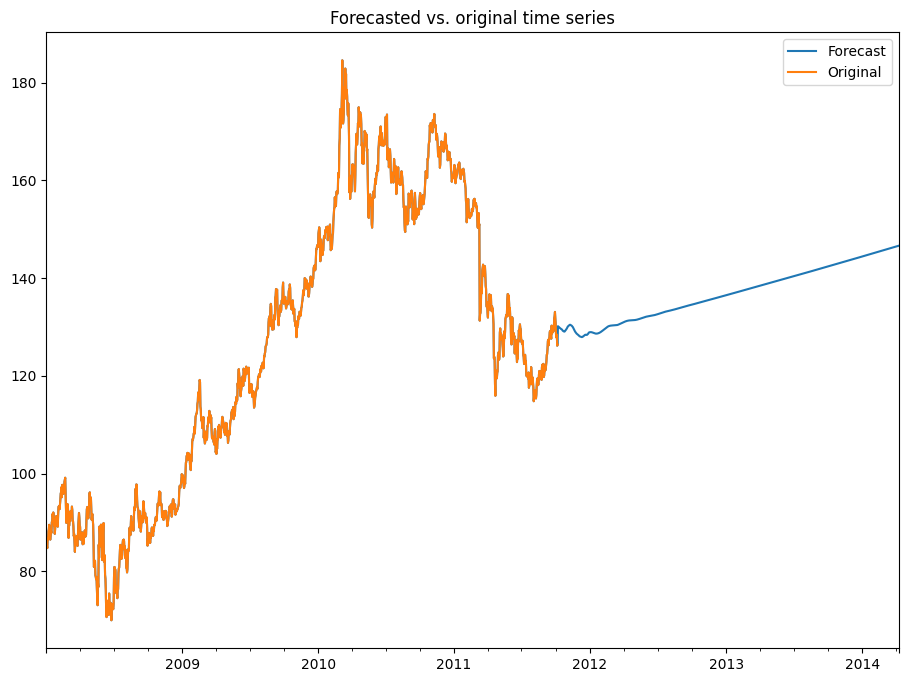

In [16]:
rcParams['figure.figsize'] = 11,8
ssa.forecast_recurrent(steps_ahead=len(y_test) + len(y_val), singular_values=streams10, plot=True)
rcParams['figure.figsize'] = 11, 4

### Price_2 7:2:1

In [1]:
from pySSA.mySSA import mySSA

import pandas as pd
import numpy as np

In [2]:
# 2. Đọc file dữ liệu chứng khoán AAPL và chia train test validate theo tỉ lệ 7:1:2
df = pd.read_csv('/content/drive/MyDrive/Study/IS403.N22.HTCL/final project/DATASET/Gold_Price_2.csv', parse_dates=True, index_col='Date')
df = df[['GLD']]
df = df.dropna() # Drop missing values
# df = df.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [3]:
test_data = test_data[["GLD"]]
test_data = test_data.reset_index(drop=True)

In [4]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['GLD'])

ssa = mySSA(train_data)

In [5]:
K = 90
suspected_seasonality = 12

In [6]:
ssa.embed(embedding_dimension=K, suspected_frequency=suspected_seasonality, verbose=True)

----------------------------------------
EMBEDDING SUMMARY:
Embedding dimension	:  84
Trajectory dimensions	: (84, 1520)
Complete dimension	: (84, 1520)
Missing dimension     	: (84, 0)


In [7]:
ssa.decompose(verbose=True)

----------------------------------------
DECOMPOSITION SUMMARY:
Rank of trajectory		: 84
Dimension of projection space	: 6
Characteristic of projection	: 0.9997


/content/pySSA/mySSA.py:153: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])


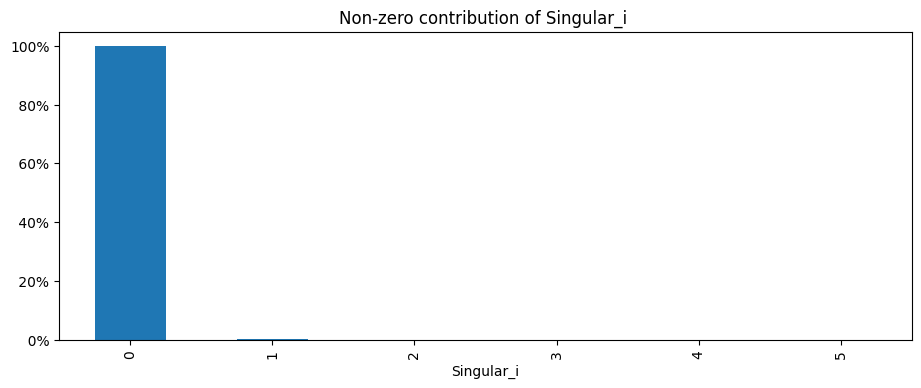

In [8]:
# First enable display of graphs in the notebook
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 11, 4

ssa.view_s_contributions()

/content/pySSA/mySSA.py:153: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])


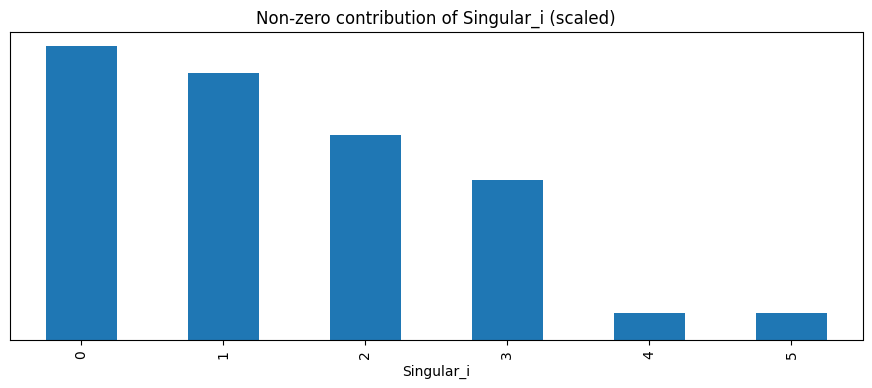

In [9]:
ssa.view_s_contributions(adjust_scale=True)

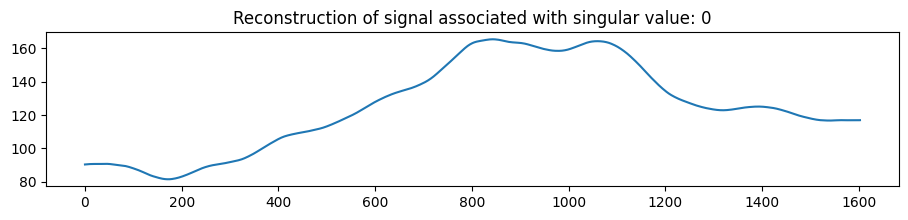

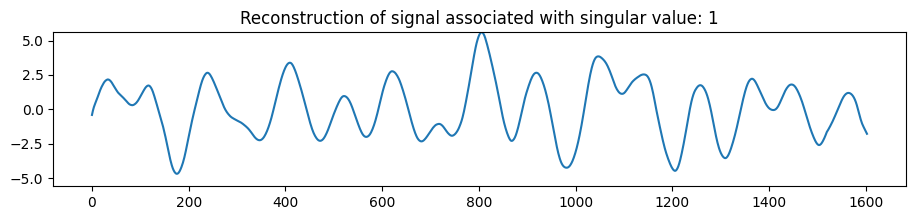

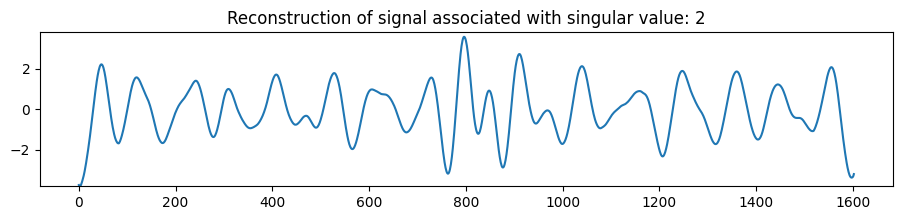

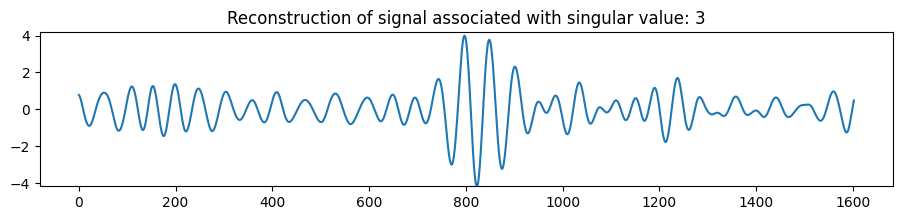

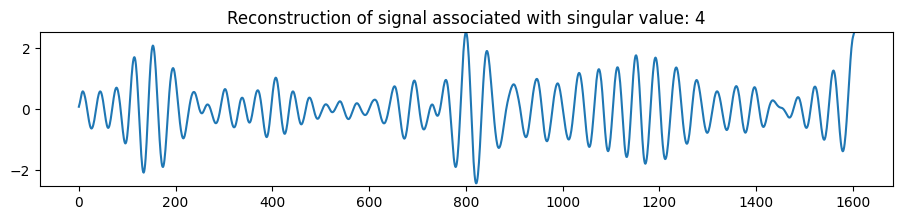

In [10]:
rcParams['figure.figsize'] = 11, 2
for i in range(5):
    ssa.view_reconstruction(ssa.Xs[i], names=i, symmetric_plots=i!=0)
rcParams['figure.figsize'] = 11, 4

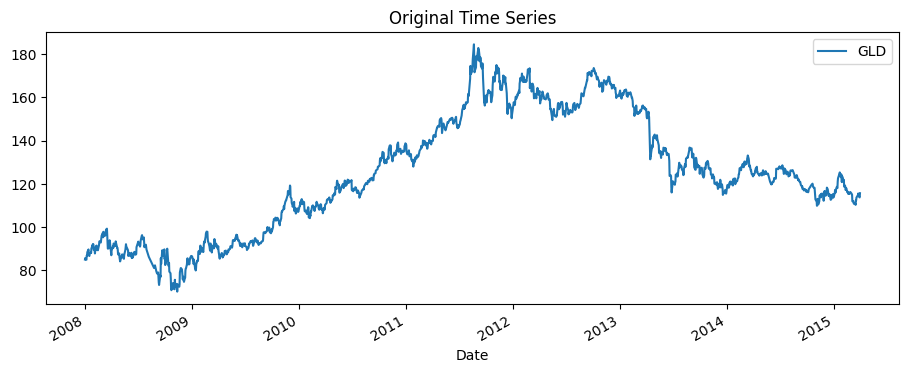

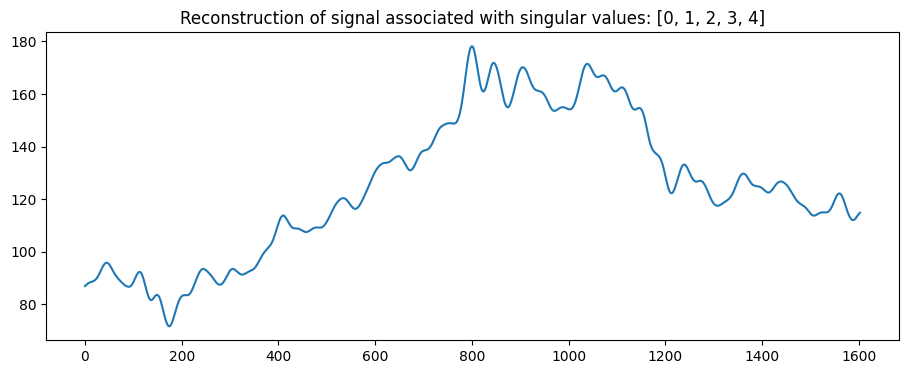

In [11]:
ssa.ts.plot(title='Original Time Series'); # This is the original series for comparison
streams5 = [i for i in range(5)]
reconstructed5 = ssa.view_reconstruction(*[ssa.Xs[i] for i in streams5], names=streams5, return_df=True)

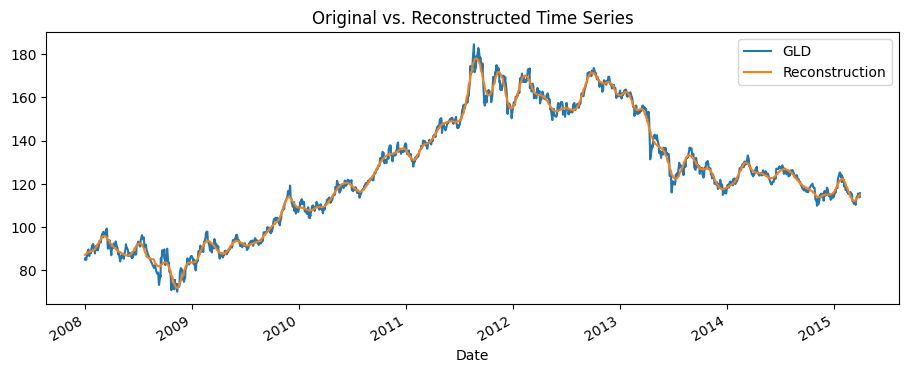

In [12]:
ts_copy5 = ssa.ts.copy()
ts_copy5['Reconstruction'] = reconstructed5.Reconstruction.values
ts_copy5.plot(title='Original vs. Reconstructed Time Series');

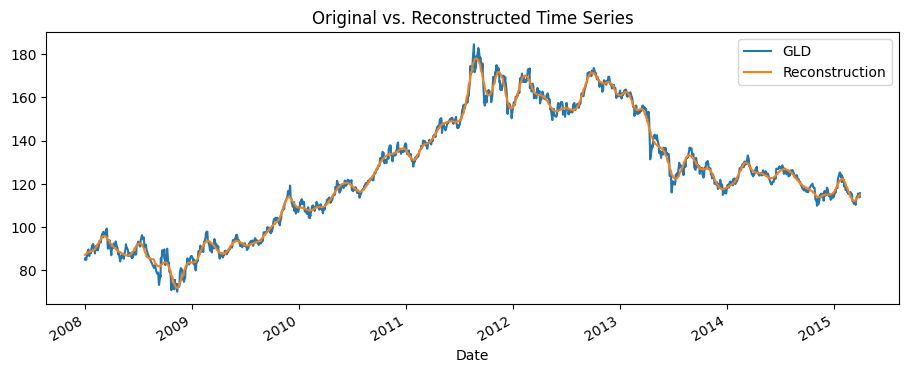

In [13]:
streams10 = [i for i in range(5)]
reconstructed10 = ssa.view_reconstruction(*[ssa.Xs[i] for i in streams10],
                                          names=streams10, return_df=True, plot=False)
ts_copy10 = ssa.ts.copy()
ts_copy10['Reconstruction'] = reconstructed10.Reconstruction.values
ts_copy10.plot(title='Original vs. Reconstructed Time Series');

In [14]:
# 4. Quá trình testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['GLD'])

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['GLD'])

steps_ahead = len(y_test) + len(y_val)
forecast_recurrent_pred = ssa.forecast_recurrent(steps_ahead=steps_ahead, singular_values=streams10, return_df=True)
a = (forecast_recurrent_pred.values[:, 0])[(len(y_train)):]
y_pred = a[:(len(y_test))]
y_pred_val = a[(len(y_test)):]

In [15]:
# 7. Đánh giá độ chính xác validate, test
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE

valid_rmse = np.sqrt(MSE(y_pred_val, y_val))
test_rmse = np.sqrt(MSE(y_test, y_pred))
valid_mape = MAPE(y_pred_val, y_val)*100
test_mape = MAPE(y_test, y_pred)*100
valid_mae = MAE(y_pred_val, y_val)
test_mae = MAE(y_test, y_pred)

print('Validation RMSE:', valid_rmse)
print('Validation MAPE:', valid_mape)
print('Validation MAE:', valid_mae)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Validation RMSE: 4.729880796471485
Validation MAPE: 3.361249965045089
Validation MAE: 4.009098179999945
Testing RMSE: 7.000327445573238
Testing MAPE: 4.979279137595637
Testing MAE: 5.616999907136866


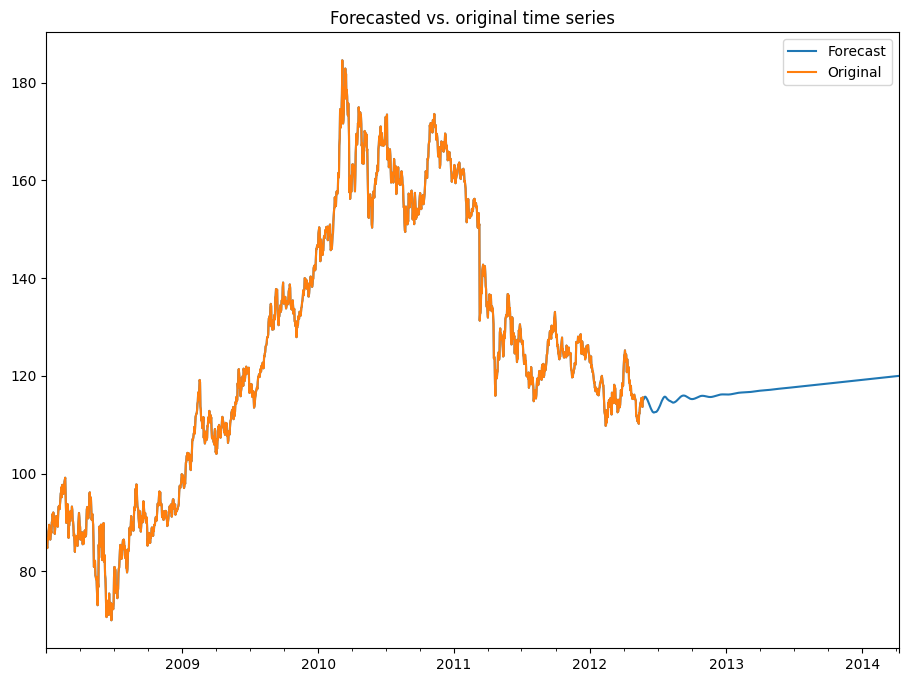

In [16]:
rcParams['figure.figsize'] = 11,8
ssa.forecast_recurrent(steps_ahead=len(y_test) + len(y_val), singular_values=streams10, plot=True)
rcParams['figure.figsize'] = 11, 4

### Price_2 8:1:1

In [1]:
from pySSA.mySSA import mySSA

import pandas as pd
import numpy as np

In [2]:
# 2. Đọc file dữ liệu chứng khoán AAPL và chia train test validate theo tỉ lệ 7:1:2
df = pd.read_csv('/content/drive/MyDrive/Study/IS403.N22.HTCL/final project/DATASET/Gold_Price_2.csv', parse_dates=True, index_col='Date')
df = df[['GLD']]
df = df.dropna() # Drop missing values
# df = df.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation sets
train_size = int(0.8 * len(df))
test_size = int(0.1 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [3]:
test_data = test_data[["GLD"]]
test_data = test_data.reset_index(drop=True)

In [4]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['GLD'])

ssa = mySSA(train_data)

In [5]:
K = 90
suspected_seasonality = 12

In [6]:
ssa.embed(embedding_dimension=K, suspected_frequency=suspected_seasonality, verbose=True)

----------------------------------------
EMBEDDING SUMMARY:
Embedding dimension	:  84
Trajectory dimensions	: (84, 1749)
Complete dimension	: (84, 1749)
Missing dimension     	: (84, 0)


In [7]:
ssa.decompose(verbose=True)

----------------------------------------
DECOMPOSITION SUMMARY:
Rank of trajectory		: 84
Dimension of projection space	: 6
Characteristic of projection	: 0.9997


/content/pySSA/mySSA.py:153: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])


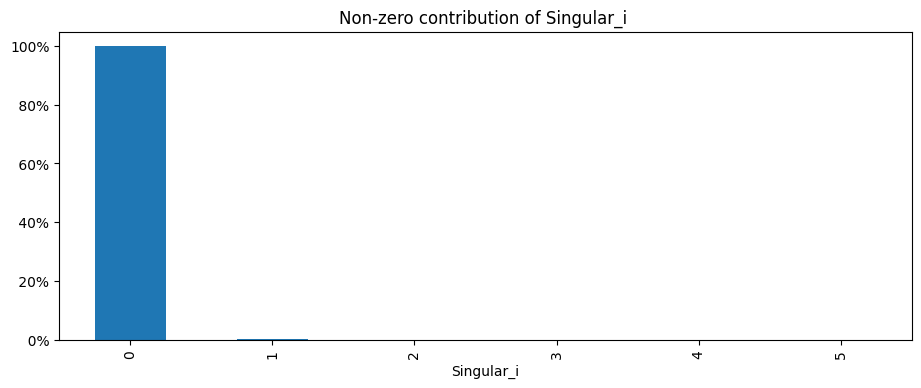

In [8]:
# First enable display of graphs in the notebook
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 11, 4

ssa.view_s_contributions()

/content/pySSA/mySSA.py:153: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])


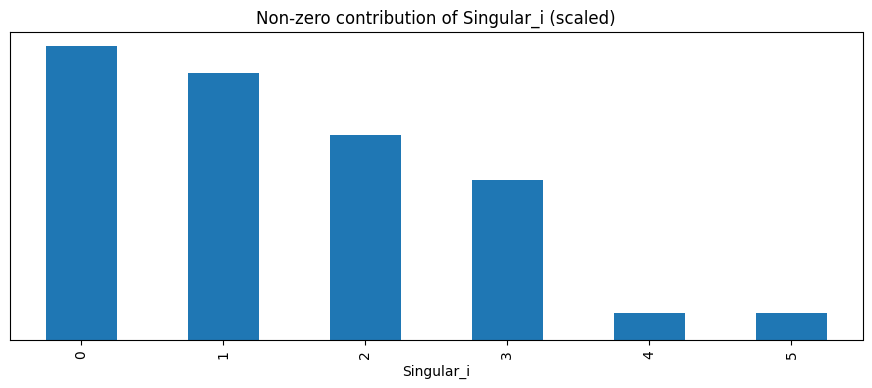

In [9]:
ssa.view_s_contributions(adjust_scale=True)

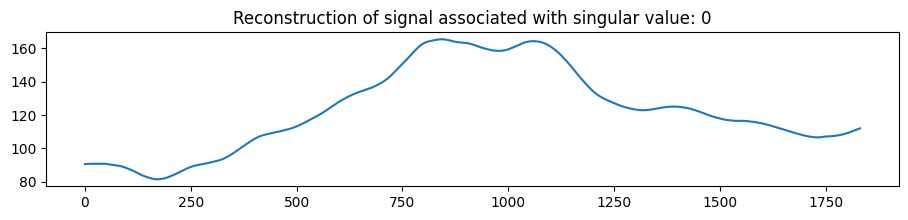

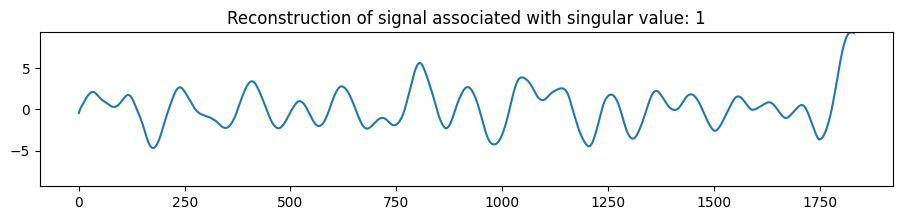

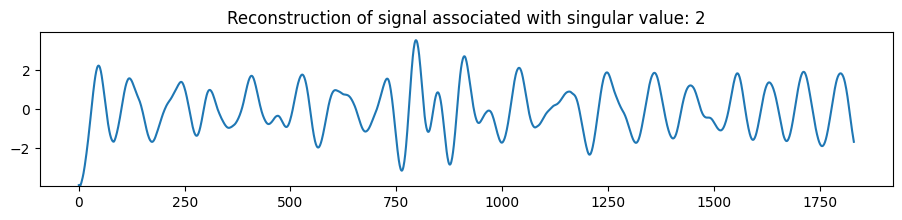

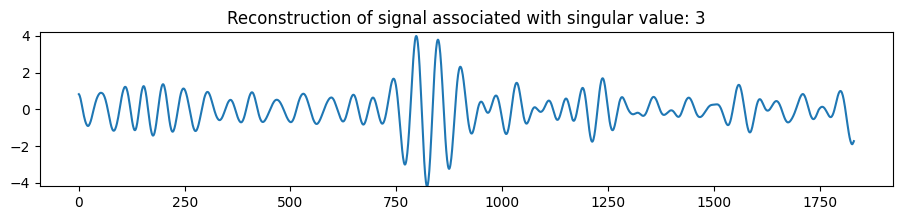

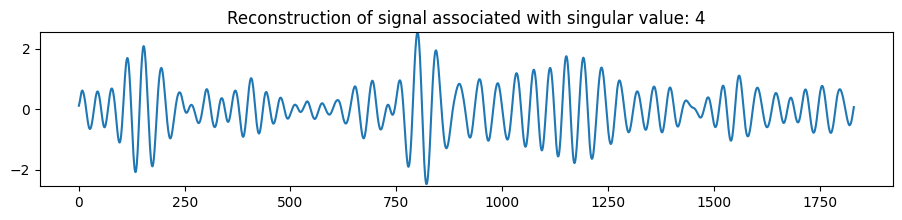

In [10]:
rcParams['figure.figsize'] = 11, 2
for i in range(5):
    ssa.view_reconstruction(ssa.Xs[i], names=i, symmetric_plots=i!=0)
rcParams['figure.figsize'] = 11, 4

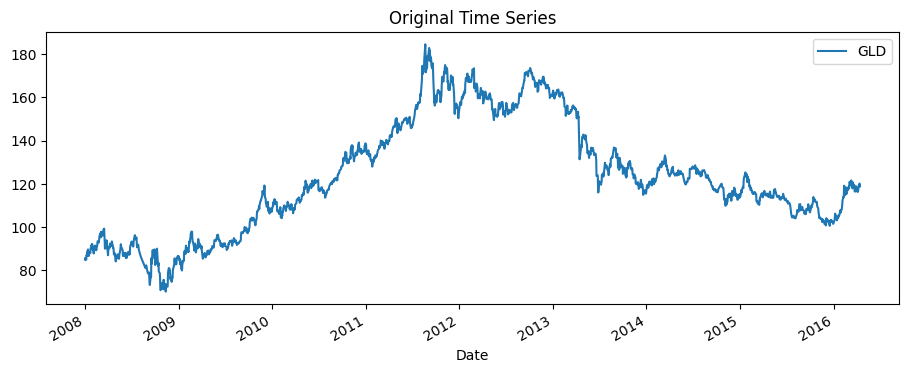

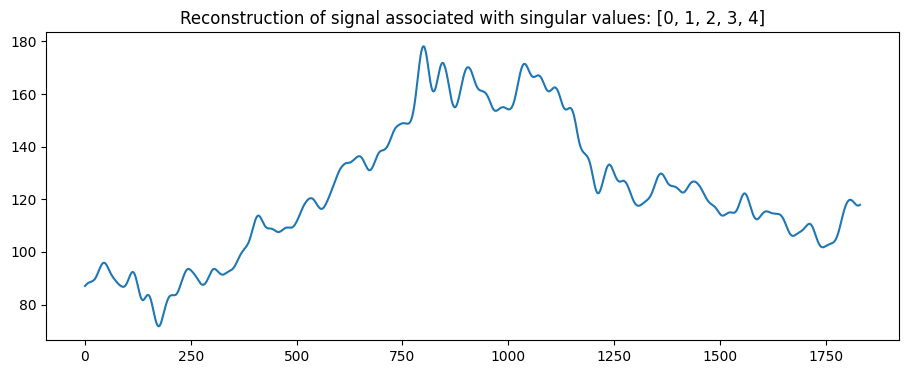

In [11]:
ssa.ts.plot(title='Original Time Series'); # This is the original series for comparison
streams5 = [i for i in range(5)]
reconstructed5 = ssa.view_reconstruction(*[ssa.Xs[i] for i in streams5], names=streams5, return_df=True)

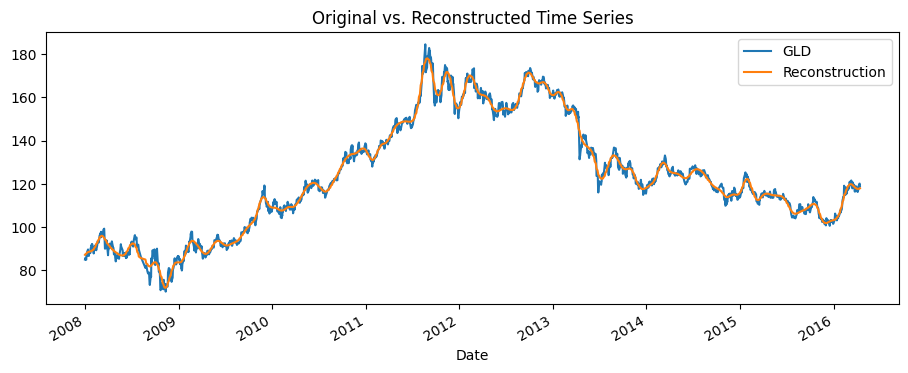

In [12]:
ts_copy5 = ssa.ts.copy()
ts_copy5['Reconstruction'] = reconstructed5.Reconstruction.values
ts_copy5.plot(title='Original vs. Reconstructed Time Series');

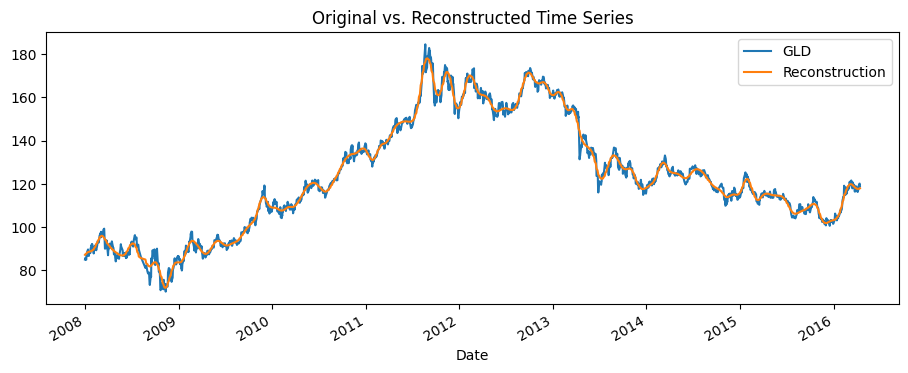

In [13]:
streams10 = [i for i in range(5)]
reconstructed10 = ssa.view_reconstruction(*[ssa.Xs[i] for i in streams10],
                                          names=streams10, return_df=True, plot=False)
ts_copy10 = ssa.ts.copy()
ts_copy10['Reconstruction'] = reconstructed10.Reconstruction.values
ts_copy10.plot(title='Original vs. Reconstructed Time Series');

In [14]:
# 4. Quá trình testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['GLD'])

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['GLD'])

steps_ahead = len(y_test) + len(y_val)
forecast_recurrent_pred = ssa.forecast_recurrent(steps_ahead=steps_ahead, singular_values=streams10, return_df=True)
a = (forecast_recurrent_pred.values[:, 0])[(len(y_train)):]
y_pred = a[:(len(y_test))]
y_pred_val = a[(len(y_test)):]

In [15]:
# 7. Đánh giá độ chính xác validate, test
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE

valid_rmse = np.sqrt(MSE(y_pred_val, y_val))
test_rmse = np.sqrt(MSE(y_test, y_pred))
valid_mape = MAPE(y_pred_val, y_val)*100
test_mape = MAPE(y_test, y_pred)*100
valid_mae = MAE(y_pred_val, y_val)
test_mae = MAE(y_test, y_pred)

print('Validation RMSE:', valid_rmse)
print('Validation MAPE:', valid_mape)
print('Validation MAE:', valid_mae)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Validation RMSE: 5.0639317678904066
Validation MAPE: 3.6504888236508064
Validation MAE: 4.338825857772845
Testing RMSE: 6.641503338899915
Testing MAPE: 4.29748923728478
Testing MAE: 5.230586721985453


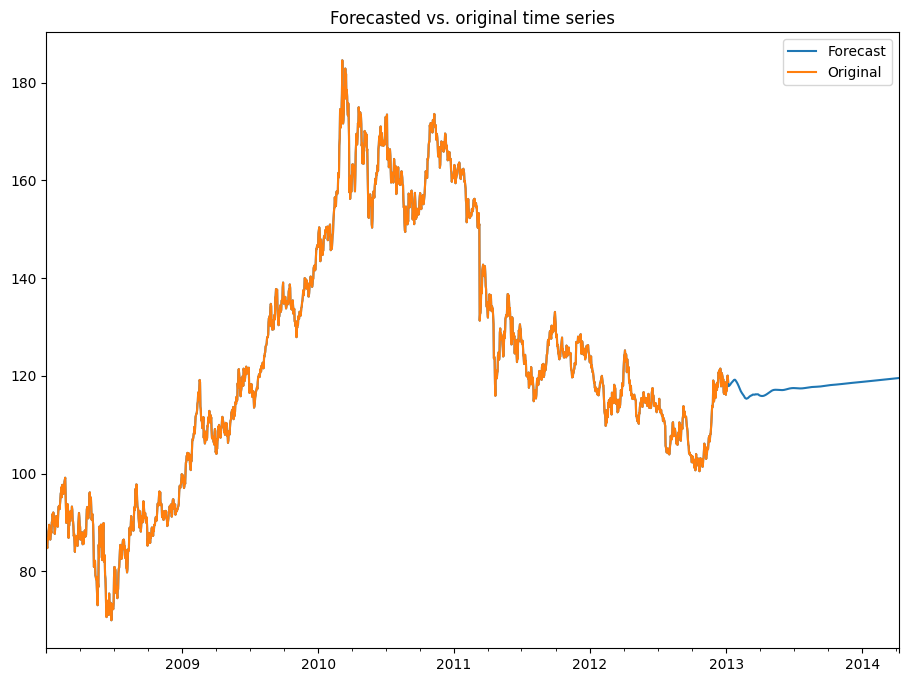

In [16]:
rcParams['figure.figsize'] = 11,8
ssa.forecast_recurrent(steps_ahead=len(y_test) + len(y_val), singular_values=streams10, plot=True)
rcParams['figure.figsize'] = 11, 4

## Price_3

### Price_3 6:3:1

In [1]:
from pySSA.mySSA import mySSA

import pandas as pd
import numpy as np

In [2]:
# 2. Đọc file dữ liệu chứng khoán AAPL và chia train test validate theo tỉ lệ 7:1:2
df = pd.read_csv('/content/drive/MyDrive/Study/IS403.N22.HTCL/final project/DATASET/Gold_Price_3.csv', parse_dates=True, index_col='Date')
df = df[['Close']]
df = df.dropna() # Drop missing values
# df = df.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation sets
train_size = int(0.6 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [3]:
test_data = test_data[["Close"]]
test_data = test_data.reset_index(drop=True)

In [4]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

ssa = mySSA(train_data)

In [5]:
K = 90
suspected_seasonality = 12

In [6]:
ssa.embed(embedding_dimension=K, suspected_frequency=suspected_seasonality, verbose=True)

----------------------------------------
EMBEDDING SUMMARY:
Embedding dimension	:  84
Trajectory dimensions	: (84, 973)
Complete dimension	: (84, 973)
Missing dimension     	: (84, 0)


In [7]:
ssa.decompose(verbose=True)

----------------------------------------
DECOMPOSITION SUMMARY:
Rank of trajectory		: 84
Dimension of projection space	: 3
Characteristic of projection	: 0.9998


/content/pySSA/mySSA.py:153: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])


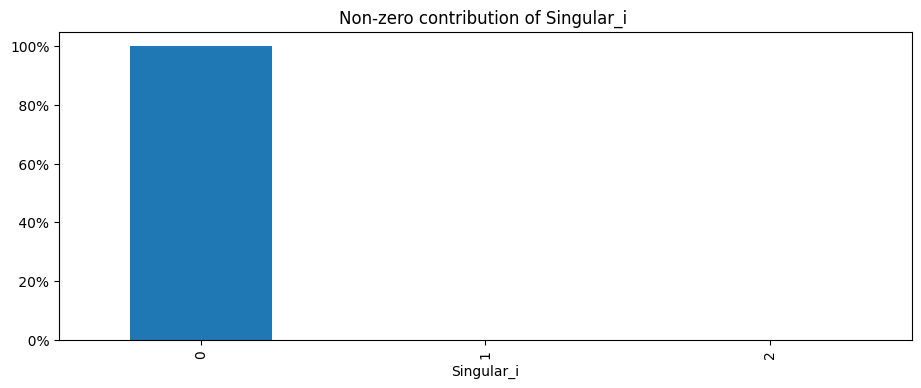

In [8]:
# First enable display of graphs in the notebook
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 11, 4

ssa.view_s_contributions()

/content/pySSA/mySSA.py:153: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])


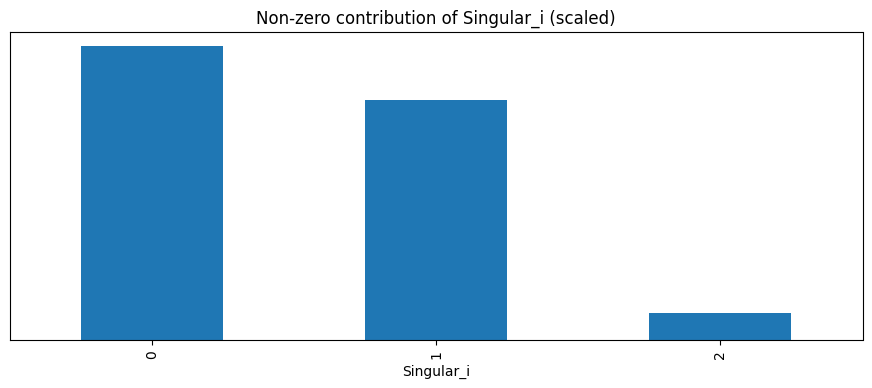

In [9]:
ssa.view_s_contributions(adjust_scale=True)

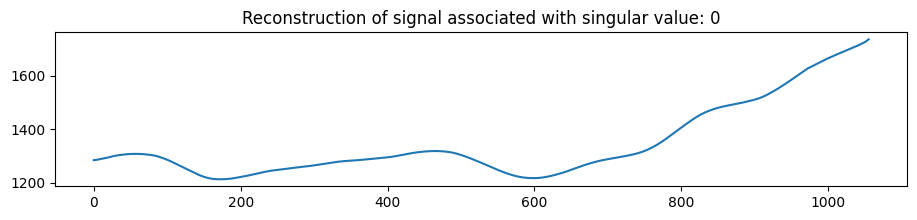

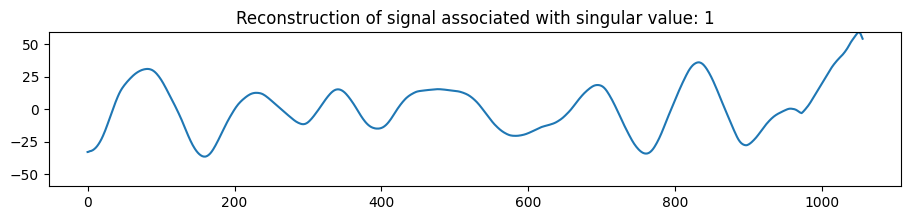

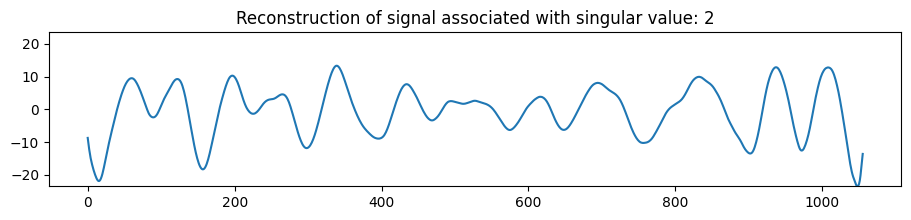

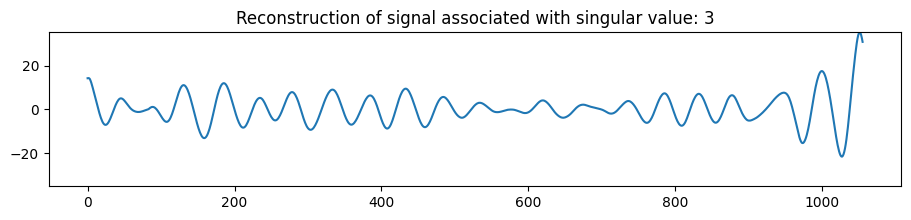

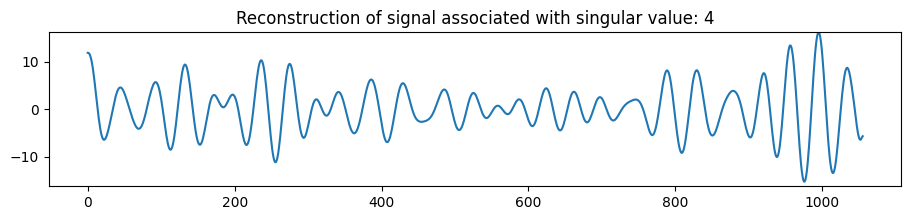

In [10]:
rcParams['figure.figsize'] = 11, 2
for i in range(5):
    ssa.view_reconstruction(ssa.Xs[i], names=i, symmetric_plots=i!=0)
rcParams['figure.figsize'] = 11, 4

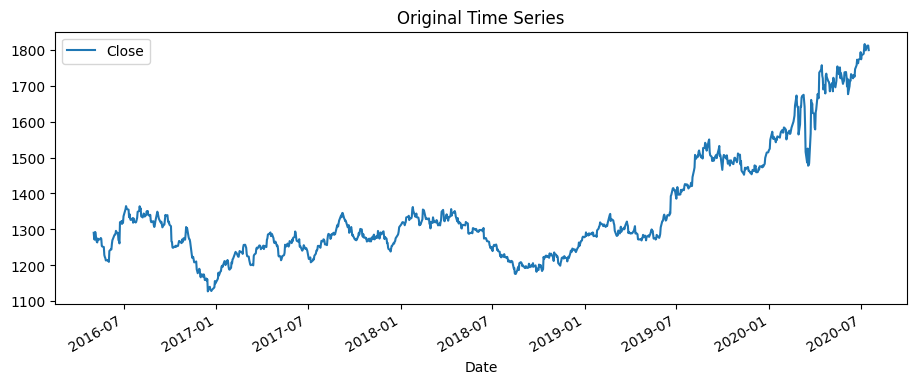

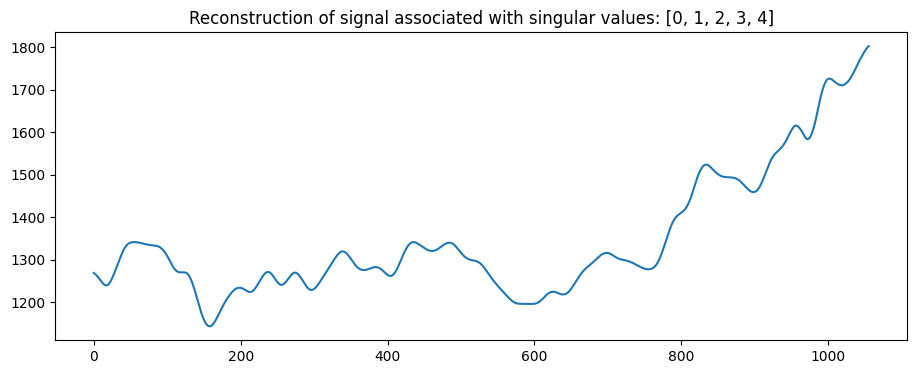

In [11]:
ssa.ts.plot(title='Original Time Series'); # This is the original series for comparison
streams5 = [i for i in range(5)]
reconstructed5 = ssa.view_reconstruction(*[ssa.Xs[i] for i in streams5], names=streams5, return_df=True)

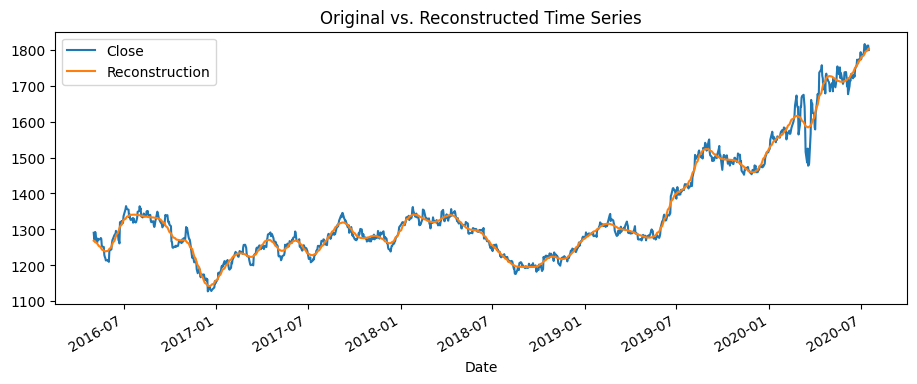

In [12]:
ts_copy5 = ssa.ts.copy()
ts_copy5['Reconstruction'] = reconstructed5.Reconstruction.values
ts_copy5.plot(title='Original vs. Reconstructed Time Series');

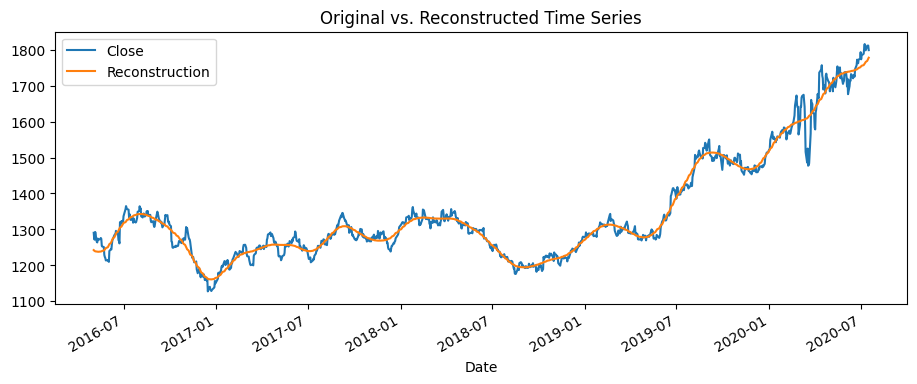

In [13]:
streams10 = [i for i in range(3)]
reconstructed10 = ssa.view_reconstruction(*[ssa.Xs[i] for i in streams10],
                                          names=streams10, return_df=True, plot=False)
ts_copy10 = ssa.ts.copy()
ts_copy10['Reconstruction'] = reconstructed10.Reconstruction.values
ts_copy10.plot(title='Original vs. Reconstructed Time Series');

In [14]:
# 4. Quá trình testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])

steps_ahead = len(y_test) + len(y_val)
forecast_recurrent_pred = ssa.forecast_recurrent(steps_ahead=steps_ahead, singular_values=streams10, return_df=True)
a = (forecast_recurrent_pred.values[:, 0])[(len(y_train)):]
y_pred = a[:(len(y_test))]
y_pred_val = a[(len(y_test)):]

In [15]:
# 7. Đánh giá độ chính xác validate, test
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE

valid_rmse = np.sqrt(MSE(y_pred_val, y_val))
test_rmse = np.sqrt(MSE(y_test, y_pred))
valid_mape = MAPE(y_pred_val, y_val)*100
test_mape = MAPE(y_test, y_pred)*100
valid_mae = MAE(y_pred_val, y_val)
test_mae = MAE(y_test, y_pred)

print('Validation RMSE:', valid_rmse)
print('Validation MAPE:', valid_mape)
print('Validation MAE:', valid_mae)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Validation RMSE: 539.8592061509065
Validation MAPE: 22.82711985348845
Validation MAE: 534.6024554504462
Testing RMSE: 252.57167065417104
Testing MAPE: 11.978497345905827
Testing MAE: 217.0098873207994


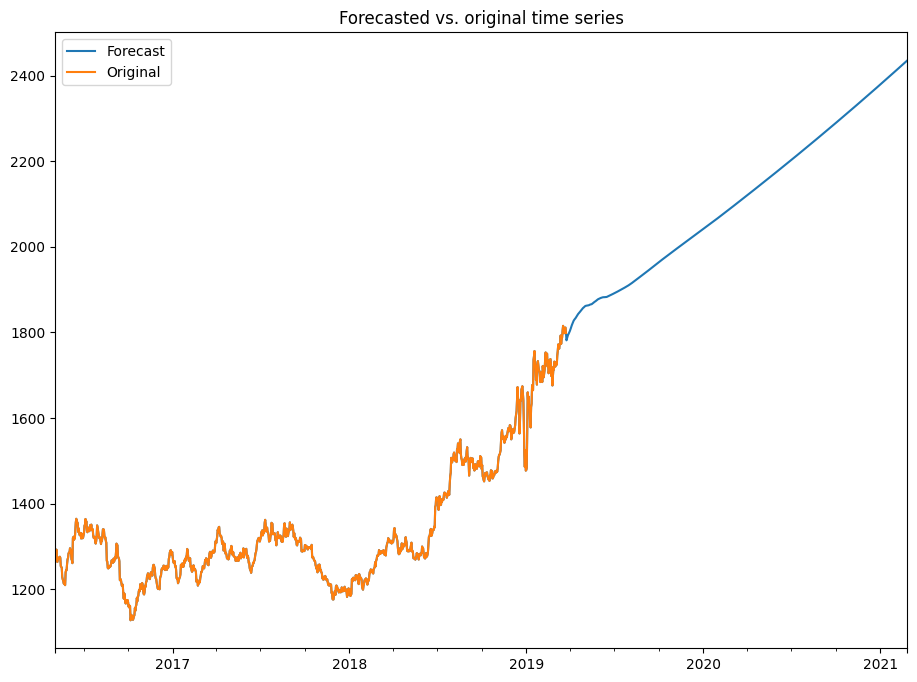

In [16]:
rcParams['figure.figsize'] = 11,8
ssa.forecast_recurrent(steps_ahead=len(y_test) + len(y_val), singular_values=streams10, plot=True)
rcParams['figure.figsize'] = 11, 4

### Price_3 7:2:1

In [1]:
from pySSA.mySSA import mySSA

import pandas as pd
import numpy as np

In [2]:
# 2. Đọc file dữ liệu chứng khoán AAPL và chia train test validate theo tỉ lệ 7:1:2
df = pd.read_csv('/content/drive/MyDrive/Study/IS403.N22.HTCL/final project/DATASET/Gold_Price_3.csv', parse_dates=True, index_col='Date')
df = df[['Close']]
df = df.dropna() # Drop missing values
# df = df.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [3]:
test_data = test_data[["Close"]]
test_data = test_data.reset_index(drop=True)

In [4]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

ssa = mySSA(train_data)

In [5]:
K = 90
suspected_seasonality = 12

In [6]:
ssa.embed(embedding_dimension=K, suspected_frequency=suspected_seasonality, verbose=True)

----------------------------------------
EMBEDDING SUMMARY:
Embedding dimension	:  84
Trajectory dimensions	: (84, 1149)
Complete dimension	: (84, 1149)
Missing dimension     	: (84, 0)


In [7]:
ssa.decompose(verbose=True)

----------------------------------------
DECOMPOSITION SUMMARY:
Rank of trajectory		: 84
Dimension of projection space	: 4
Characteristic of projection	: 0.9998


/content/pySSA/mySSA.py:153: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])


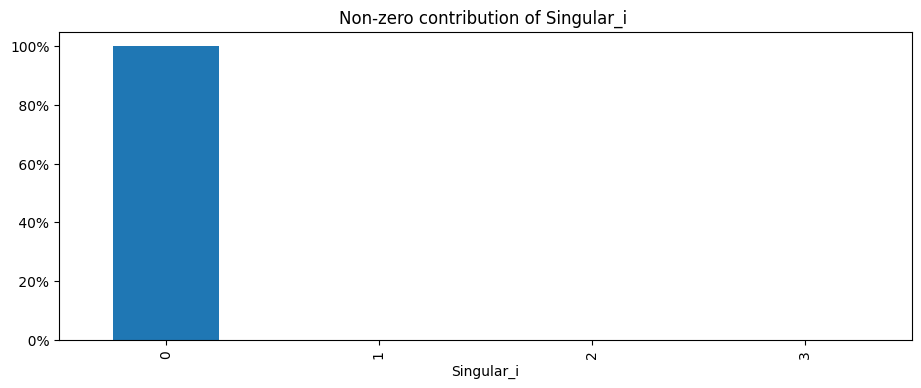

In [8]:
# First enable display of graphs in the notebook
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 11, 4

ssa.view_s_contributions()

/content/pySSA/mySSA.py:153: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])


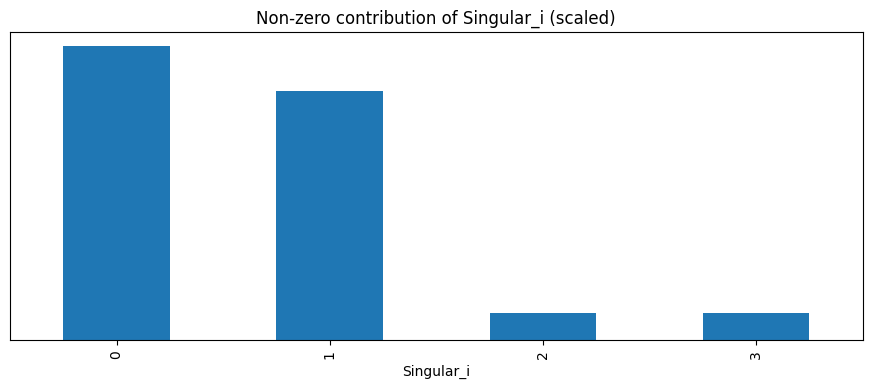

In [9]:
ssa.view_s_contributions(adjust_scale=True)

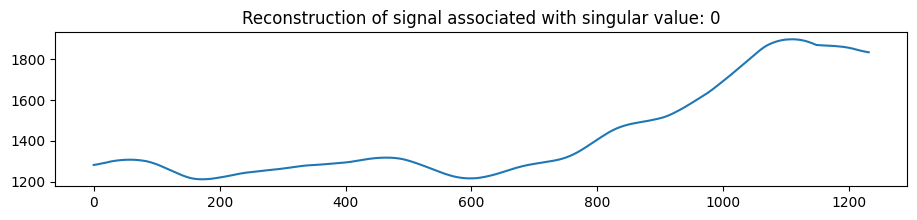

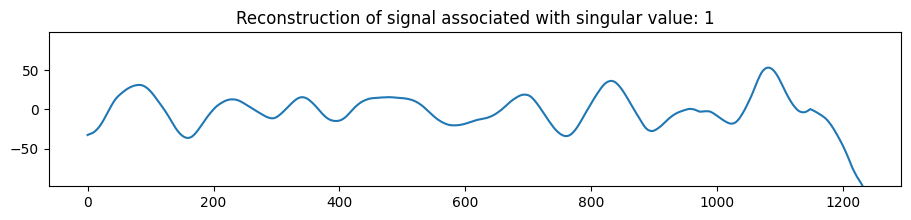

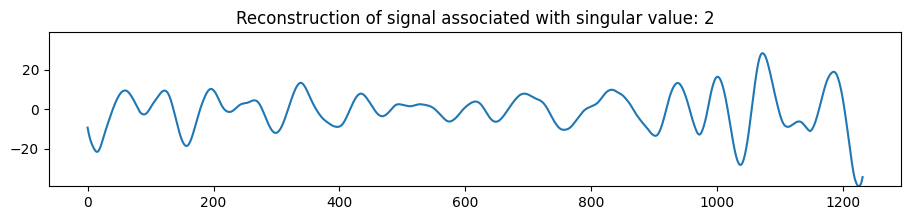

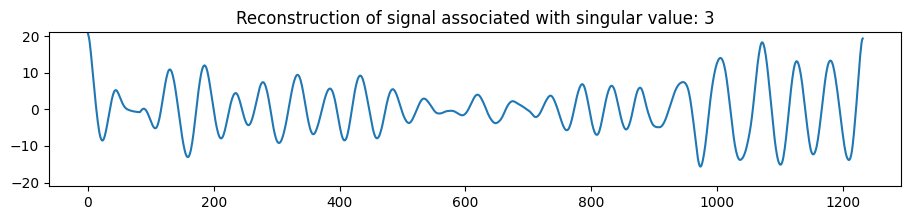

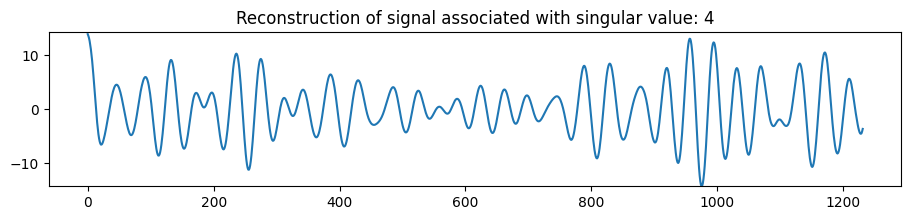

In [10]:
rcParams['figure.figsize'] = 11, 2
for i in range(5):
    ssa.view_reconstruction(ssa.Xs[i], names=i, symmetric_plots=i!=0)
rcParams['figure.figsize'] = 11, 4

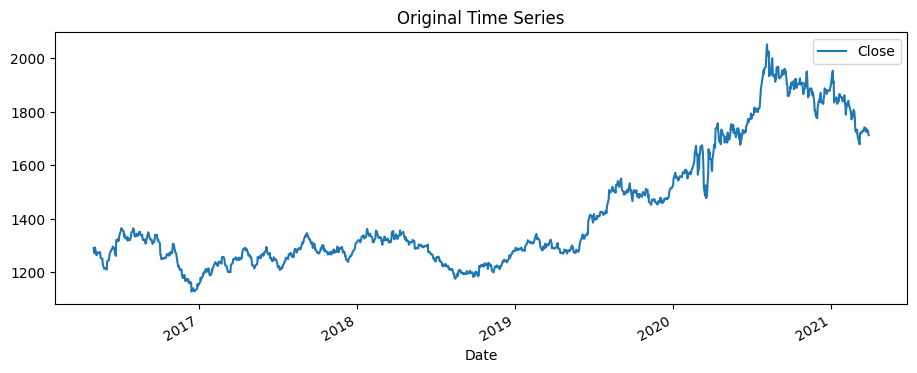

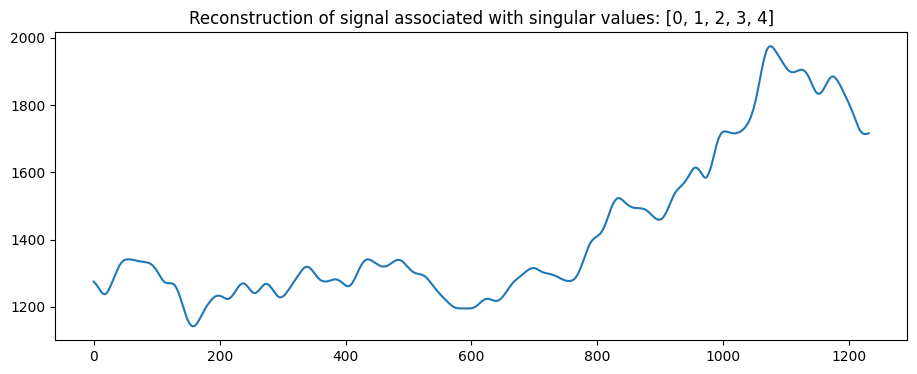

In [11]:
ssa.ts.plot(title='Original Time Series'); # This is the original series for comparison
streams5 = [i for i in range(5)]
reconstructed5 = ssa.view_reconstruction(*[ssa.Xs[i] for i in streams5], names=streams5, return_df=True)

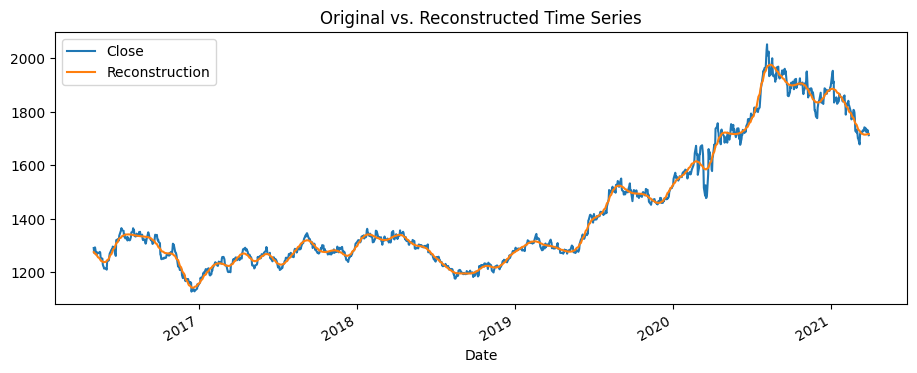

In [12]:
ts_copy5 = ssa.ts.copy()
ts_copy5['Reconstruction'] = reconstructed5.Reconstruction.values
ts_copy5.plot(title='Original vs. Reconstructed Time Series');

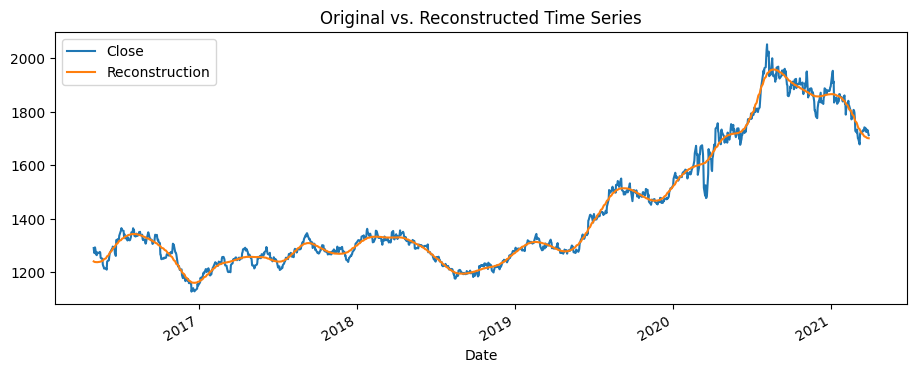

In [13]:
streams10 = [i for i in range(3)]
reconstructed10 = ssa.view_reconstruction(*[ssa.Xs[i] for i in streams10],
                                          names=streams10, return_df=True, plot=False)
ts_copy10 = ssa.ts.copy()
ts_copy10['Reconstruction'] = reconstructed10.Reconstruction.values
ts_copy10.plot(title='Original vs. Reconstructed Time Series');

In [14]:
# 4. Quá trình testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])

steps_ahead = len(y_test) + len(y_val)
forecast_recurrent_pred = ssa.forecast_recurrent(steps_ahead=steps_ahead, singular_values=streams10, return_df=True)
a = (forecast_recurrent_pred.values[:, 0])[(len(y_train)):]
y_pred = a[:(len(y_test))]
y_pred_val = a[(len(y_test)):]

In [15]:
# 7. Đánh giá độ chính xác validate, test
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE

valid_rmse = np.sqrt(MSE(y_pred_val, y_val))
test_rmse = np.sqrt(MSE(y_test, y_pred))
valid_mape = MAPE(y_pred_val, y_val)*100
test_mape = MAPE(y_test, y_pred)*100
valid_mae = MAE(y_pred_val, y_val)
test_mae = MAE(y_test, y_pred)

print('Validation RMSE:', valid_rmse)
print('Validation MAPE:', valid_mape)
print('Validation MAE:', valid_mae)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Validation RMSE: 135.89208738326855
Validation MAPE: 6.0030136645610295
Validation MAE: 113.88785217864474
Testing RMSE: 81.12527424435066
Testing MAPE: 3.3456165945787326
Testing MAE: 61.570355914259814


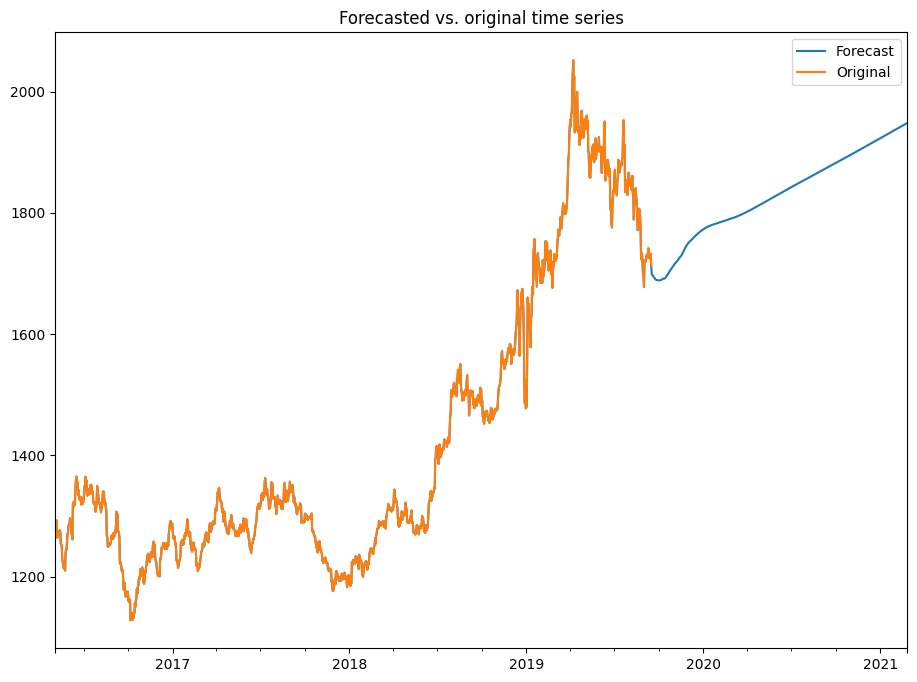

In [16]:
rcParams['figure.figsize'] = 11,8
ssa.forecast_recurrent(steps_ahead=len(y_test) + len(y_val), singular_values=streams10, plot=True)
rcParams['figure.figsize'] = 11, 4

In [17]:
from pySSA.mySSA import mySSA

import pandas as pd
import numpy as np

In [18]:
ts = pd.read_csv('/content/Gold_Price_3.csv', parse_dates=True, index_col='Date')
ts = ts[['Close']]

FileNotFoundError: ignored

In [ ]:
# 2. Đọc file dữ liệu chứng khoán AAPL và chia train test validate theo tỉ lệ 7:1:2
df = pd.read_csv('/content/Gold_Price_3.csv', parse_dates=True, index_col='Date')
df = df[['Close']]
df = df.dropna() # Drop missing values
# df = df.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [ ]:
test_data = test_data[["Close"]]
test_data = test_data.reset_index(drop=True)

In [ ]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

ssa = mySSA(train_data)

In [ ]:
K = 90
suspected_seasonality = 12

In [ ]:
ssa.embed(embedding_dimension=K, suspected_frequency=suspected_seasonality, verbose=True)

In [ ]:
ssa.decompose(verbose=True)

In [ ]:
# First enable display of graphs in the notebook
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 11, 4

ssa.view_s_contributions()

In [ ]:
ssa.view_s_contributions(adjust_scale=True)

In [ ]:
rcParams['figure.figsize'] = 11, 2
for i in range(5):
    ssa.view_reconstruction(ssa.Xs[i], names=i, symmetric_plots=i!=0)
rcParams['figure.figsize'] = 11, 4

In [ ]:
ssa.ts.plot(title='Original Time Series'); # This is the original series for comparison
streams5 = [i for i in range(5)]
reconstructed5 = ssa.view_reconstruction(*[ssa.Xs[i] for i in streams5], names=streams5, return_df=True)

In [ ]:
ts_copy5 = ssa.ts.copy()
ts_copy5['Reconstruction'] = reconstructed5.Reconstruction.values
ts_copy5.plot(title='Original vs. Reconstructed Time Series');

In [ ]:
streams10 = [i for i in range(3)]
reconstructed10 = ssa.view_reconstruction(*[ssa.Xs[i] for i in streams10],
                                          names=streams10, return_df=True, plot=False)
ts_copy10 = ssa.ts.copy()
ts_copy10['Reconstruction'] = reconstructed10.Reconstruction.values
ts_copy10.plot(title='Original vs. Reconstructed Time Series');

In [ ]:
# 4. Quá trình testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])

steps_ahead = len(y_test) + len(y_val)
forecast_recurrent_pred = ssa.forecast_recurrent(steps_ahead=steps_ahead, singular_values=streams10, return_df=True)
a = (forecast_recurrent_pred.values[:, 0])[(len(y_train)):]
y_pred = a[:(len(y_test))]
y_pred_val = a[(len(y_test)):]

In [ ]:
# 7. Đánh giá độ chính xác validate, test
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE

valid_rmse = np.sqrt(MSE(y_pred_val, y_val))
test_rmse = np.sqrt(MSE(y_test, y_pred))
valid_mape = MAPE(y_pred_val, y_val)*100
test_mape = MAPE(y_test, y_pred)*100
valid_mae = MAE(y_pred_val, y_val)
test_mae = MAE(y_test, y_pred)

print('Validation RMSE:', valid_rmse)
print('Validation MAPE:', valid_mape)
print('Validation MAE:', valid_mae)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

In [ ]:
rcParams['figure.figsize'] = 11,8
ssa.forecast_recurrent(steps_ahead=len(y_test) + len(y_val), singular_values=streams10, plot=True)
rcParams['figure.figsize'] = 11, 4

### Price_3 8:1:1

In [ ]:
from pySSA.mySSA import mySSA

import pandas as pd
import numpy as np

In [ ]:
# 2. Đọc file dữ liệu chứng khoán AAPL và chia train test validate theo tỉ lệ 7:1:2
df = pd.read_csv('/content/drive/MyDrive/Study/IS403.N22.HTCL/final project/DATASET/Gold_Price_3.csv', parse_dates=True, index_col='Date')
df = df[['Close']]
df = df.dropna() # Drop missing values
# df = df.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation sets
train_size = int(0.8 * len(df))
test_size = int(0.1 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [ ]:
test_data = test_data[["Close"]]
test_data = test_data.reset_index(drop=True)

In [ ]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

ssa = mySSA(train_data)

In [ ]:
K = 90
suspected_seasonality = 12

In [ ]:
ssa.embed(embedding_dimension=K, suspected_frequency=suspected_seasonality, verbose=True)

----------------------------------------
EMBEDDING SUMMARY:
Embedding dimension	:  84
Trajectory dimensions	: (84, 1325)
Complete dimension	: (84, 1325)
Missing dimension     	: (84, 0)


In [ ]:
ssa.decompose(verbose=True)

----------------------------------------
DECOMPOSITION SUMMARY:
Rank of trajectory		: 84
Dimension of projection space	: 4
Characteristic of projection	: 0.9998


/content/pySSA/mySSA.py:153: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])


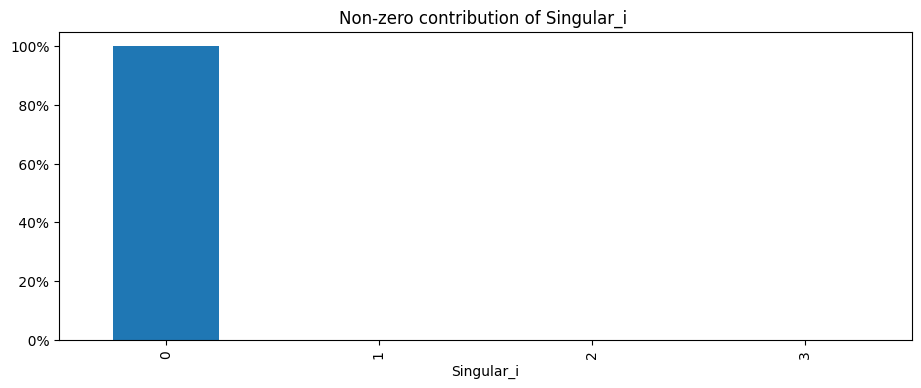

In [ ]:
# First enable display of graphs in the notebook
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 11, 4

ssa.view_s_contributions()

/content/pySSA/mySSA.py:153: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])


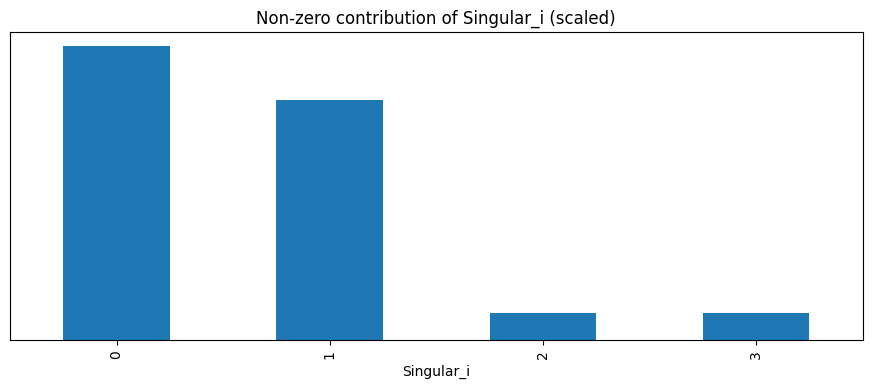

In [ ]:
ssa.view_s_contributions(adjust_scale=True)

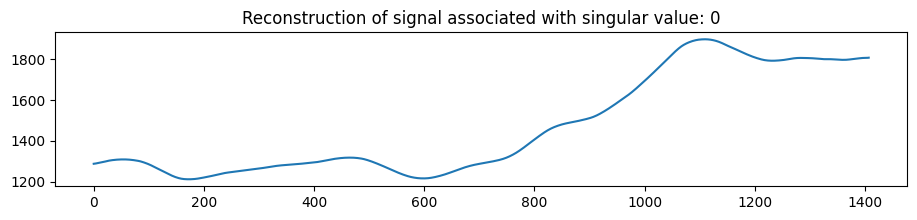

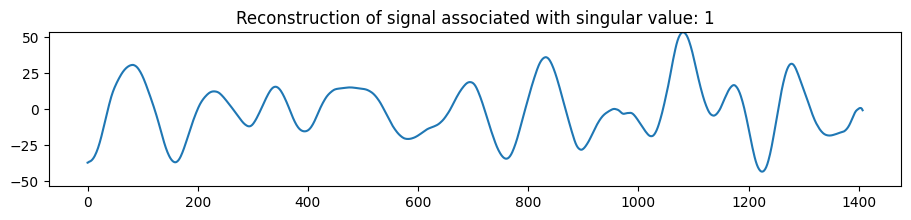

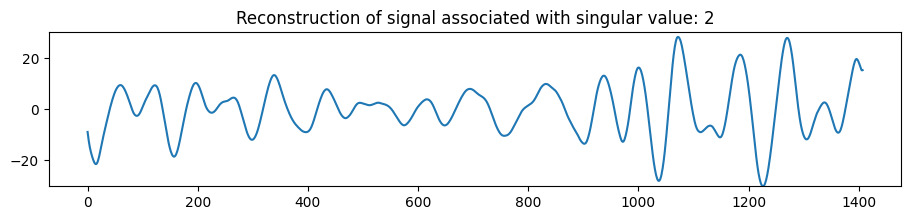

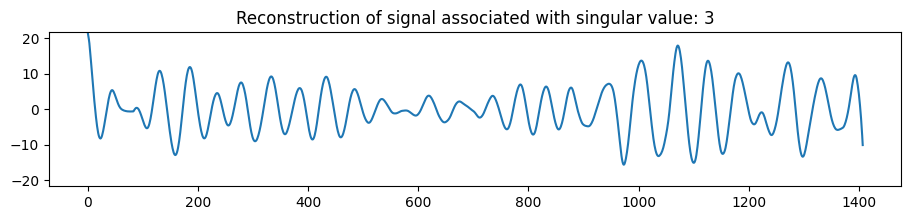

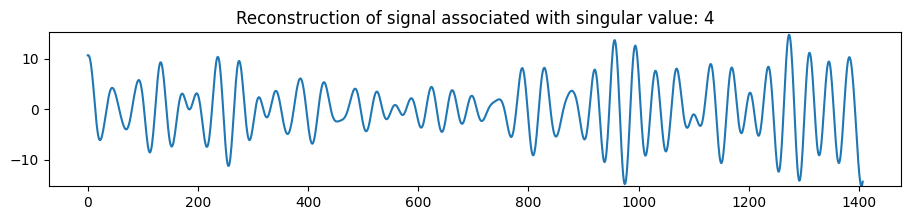

In [ ]:
rcParams['figure.figsize'] = 11, 2
for i in range(5):
    ssa.view_reconstruction(ssa.Xs[i], names=i, symmetric_plots=i!=0)
rcParams['figure.figsize'] = 11, 4

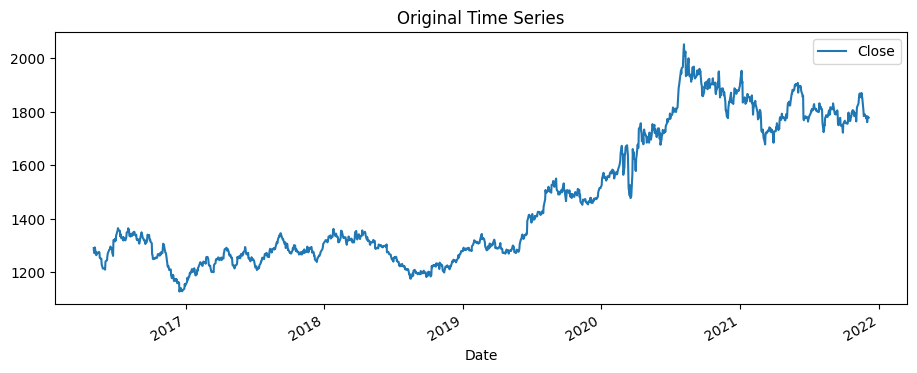

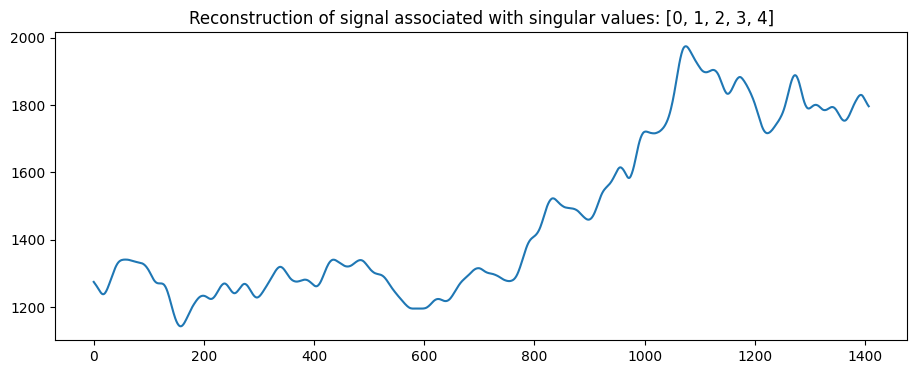

In [ ]:
ssa.ts.plot(title='Original Time Series'); # This is the original series for comparison
streams5 = [i for i in range(5)]
reconstructed5 = ssa.view_reconstruction(*[ssa.Xs[i] for i in streams5], names=streams5, return_df=True)

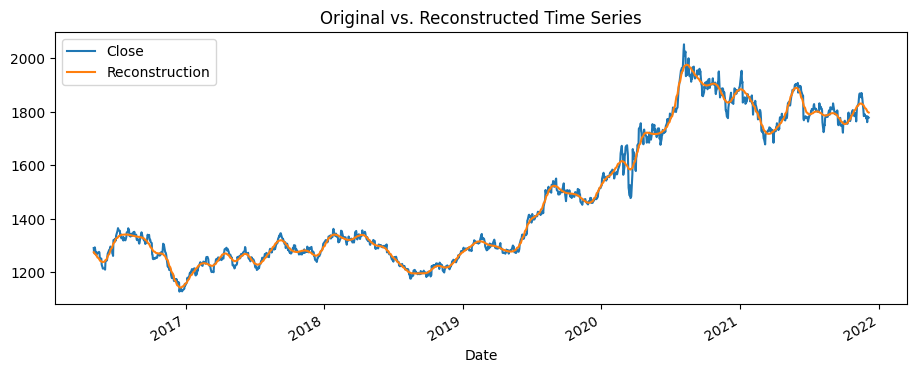

In [ ]:
ts_copy5 = ssa.ts.copy()
ts_copy5['Reconstruction'] = reconstructed5.Reconstruction.values
ts_copy5.plot(title='Original vs. Reconstructed Time Series');

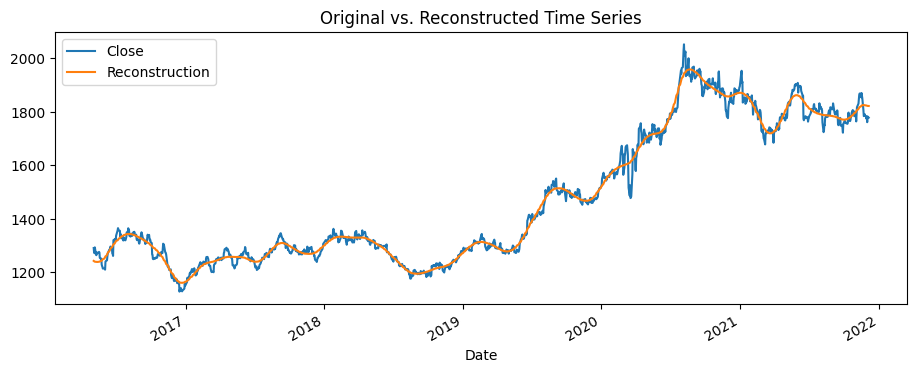

In [ ]:
streams10 = [i for i in range(3)]
reconstructed10 = ssa.view_reconstruction(*[ssa.Xs[i] for i in streams10],
                                          names=streams10, return_df=True, plot=False)
ts_copy10 = ssa.ts.copy()
ts_copy10['Reconstruction'] = reconstructed10.Reconstruction.values
ts_copy10.plot(title='Original vs. Reconstructed Time Series');

In [ ]:
# 4. Quá trình testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])

steps_ahead = len(y_test) + len(y_val)
forecast_recurrent_pred = ssa.forecast_recurrent(steps_ahead=steps_ahead, singular_values=streams10, return_df=True)
a = (forecast_recurrent_pred.values[:, 0])[(len(y_train)):]
y_pred = a[:(len(y_test))]
y_pred_val = a[(len(y_test)):]

In [ ]:
# 7. Đánh giá độ chính xác validate, test
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE

valid_rmse = np.sqrt(MSE(y_pred_val, y_val))
test_rmse = np.sqrt(MSE(y_test, y_pred))
valid_mape = MAPE(y_pred_val, y_val)*100
test_mape = MAPE(y_test, y_pred)*100
valid_mae = MAE(y_pred_val, y_val)
test_mae = MAE(y_test, y_pred)

print('Validation RMSE:', valid_rmse)
print('Validation MAPE:', valid_mape)
print('Validation MAE:', valid_mae)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Validation RMSE: 149.59549931990438
Validation MAPE: 6.523161836550012
Validation MAE: 124.94001106703688
Testing RMSE: 83.69279648288493
Testing MAPE: 3.6229330677055276
Testing MAE: 66.618367917939


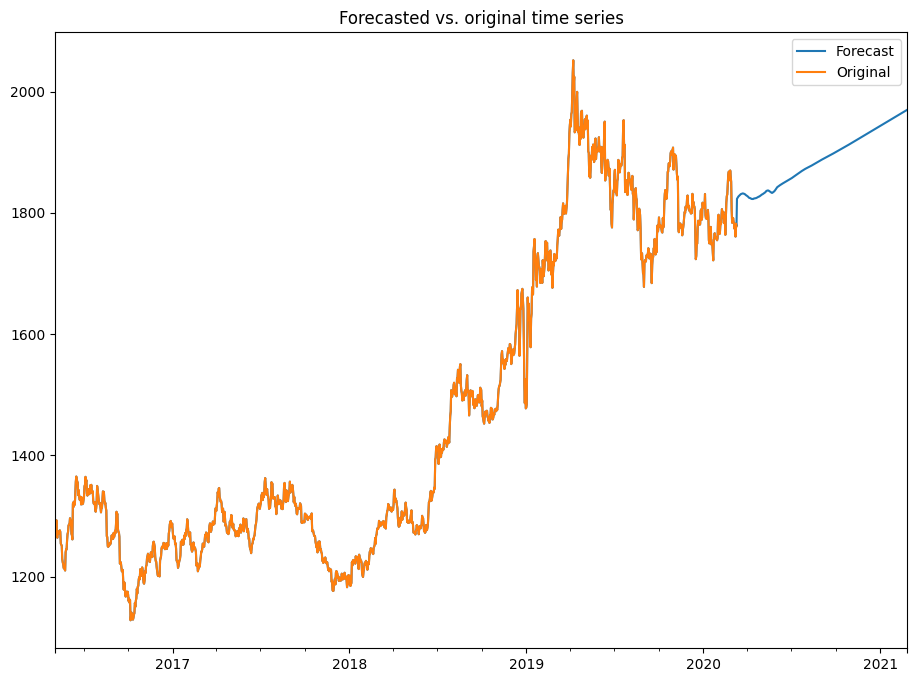

In [ ]:
rcParams['figure.figsize'] = 11,8
ssa.forecast_recurrent(steps_ahead=len(y_test) + len(y_val), singular_values=streams10, plot=True)
rcParams['figure.figsize'] = 11, 4